In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import os
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from football_loader import metrics, football_loader
liverpool_red = '#c8102E'
chelsea_blue = '#034694'
mancity_blue = '#6CABDD'
tottenham_blue = '#132257'
manutd_red ='#DA291C'

In [17]:
def make_features(df, teams):
    # df_league = None
    ret = {}
    # if teams is None:
    #     teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
    #     teams.sort()
    for team in teams:

        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        df_ret = pd.DataFrame(
            data={
                'Year': df_team['Year'],
                'Date': df_team['Date'],
                'Team': team,
                'HomeMatch': df_team['HomeTeam'] == team
            }
        )
        df_ret['Opponent'] = np.where(df_ret['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
        # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
        # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
        # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
        # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
        # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
        # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
        df_ret['FTR'] = df_team['FTR']
        # all['Won'] = np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
        df_ret['Won'] = np.where(df_team['FTR'] == '', False, np.where(df_ret['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A'))
        df_ret['Draw'] = np.where(df_team['FTR'] == '', False, df_team['FTR'] == 'D')
        df_ret['Lost'] = np.where(df_team['FTR'] == '', False, np.where(df_ret['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H'))
        df_ret['Result'] = np.where(df_team['FTR'] == '', '', np.where(df_ret['Won'], 'Win', (np.where(df_ret['Lost'], 'Lose', 'Draw'))))
        # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
        df_ret['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        df_ret['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        df_ret['B365Say'] = np.where(df_ret['HomeMatch'],
                                  # home match
                                  np.where(df_ret['B365Max'] == df_team['B365H'], -1,
                                           np.where(df_ret['B365Max'] == df_team['B365A'], 1,
                                                    0)),
                                  # away match
                                  np.where(df_ret['B365Max'] == df_team['B365H'], 1,
                                           np.where(df_ret['B365Max'] == df_team['B365A'], -1,
                                                    0))
                                  )
        df_ret['B365SayWin'] = np.where(df_ret['HomeMatch'],
                                  # home match
                                  np.where(df_ret['B365Max'] == df_team['B365H'],False, # lose
                                           np.where(df_ret['B365Max'] == df_team['B365A'], True, # Win
                                                    False)),
                                  # away match
                                  np.where(df_ret['B365Max'] == df_team['B365A'], False,  # lose
                                           np.where(df_ret['B365Max'] == df_team['B365H'], True,  # Win
                                                    False)))
        df_ret['B365SayLose'] = np.where(df_ret['HomeMatch'],
                              # home match
                              np.where(df_ret['B365Max'] == df_team['B365H'],True, # lose
                                       np.where(df_ret['B365Max'] == df_team['B365A'], False, # Win
                                                False)),
                              # away match
                              np.where(df_ret['B365Max'] == df_team['B365A'], True,  # lose
                                       np.where(df_ret['B365Max'] == df_team['B365H'], False,  # Win
                                                False)))
        df_ret['B365SayDraw'] = np.where(df_ret['HomeMatch'],
                              # home match
                              np.where(df_ret['B365Max'] == df_team['B365H'],False, # lose
                                       np.where(df_ret['B365Max'] == df_team['B365A'], False, # Win
                                                True)),
                              # away match
                              np.where(df_ret['B365Max'] == df_team['B365A'], False,  # lose
                                       np.where(df_ret['B365Max'] == df_team['B365H'], False,  # Win
                                                True)))

        df_ret['B365Diff'] = np.where(df_ret['B365Say'] == 1, df_ret['B365Min'] - df_ret['B365Max'],
                                   np.where(df_ret['B365Say'] == -1, df_ret['B365Max'] - df_ret['B365Min'],
                                            # draw
                                            np.where(df_ret['HomeMatch'],
                                            df_team['B365A'] - df_team['B365H'],
                                            df_team['B365H'] - df_team['B365A']
                                            ))) * -1
        
        df_ret['Corners'] = np.where(df_ret['HomeMatch'], df_team['HC'], df_team['AC'])
        df_ret['Shots'] = np.where(df_ret['HomeMatch'], df_team['HS'], df_team['AS'])
        df_ret['ShotsOnTarget'] = np.where(df_ret['HomeMatch'], df_team['HST'], df_team['AST'])
        df_ret['Points'] = np.where(df_ret['Won'], 3,
                                 np.where(df_ret['Draw'], 1, 0)
                                  )
        df_ret['AdjustedPoints'] = np.where(df_ret['HomeMatch'],
                                  # home match
                                         np.where(df_ret['Won'], 1,
                                                  np.where(df_ret['Draw'], 0, -1)
                                                  )
                                         ,
                                  # away match
                                         np.where(df_ret['Won'], 1.5,
                                                  np.where(df_ret['Draw'], 0.5, 0)
                                                  )
                                  )
        df_ret['Goals'] = np.where(df_ret['HomeMatch'], df_team['FTHG'], df_team['FTAG'])
        df_ret['Conceded'] = np.where(df_ret['HomeMatch'], df_team['FTAG'], df_team['FTHG'])

        # find number of times won against this opponent in last 5 meetings
        for key, groupByOpponent in df_ret.groupby('Opponent'):
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByOpponent.index

            # make match day an index because rolling need an index date
            xx = groupByOpponent.set_index('Date')
            xx['idx'] = idx
            # shift to exclude self
            xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentLost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentLost'] = xx['Lost'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            df_ret.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
            df_ret.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
            df_ret.loc[xx.index, 'Last5AgainstThisOpponentLost'] = xx['Last5AgainstThisOpponentLost']
            df_ret.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
            df_ret.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
            df_ret.loc[xx.index, 'Last3AgainstThisOpponentLost'] = xx['Last3AgainstThisOpponentLost']
            df_ret.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
            df_ret.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']
            df_ret.loc[xx.index, 'LastAgainstThisOpponentLost'] = xx['LastAgainstThisOpponentLost']
            # X.loc[xx.index, 'LastThisOpponentLost'] = xx['LastThisOpponentLost']

        # stats by year/season
        for year, groupByYear in df_ret.groupby('Year'):
            # print(year)
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByYear.index

            # make match day an index because rolling need an index date
            xx = groupByYear.set_index('Date')
            xx['idx'] = idx

            # shift to exclude self
            xx['CornersSoFar'] = np.nancumsum(xx['Corners'].shift())
            xx['ShotsSoFar'] = np.nancumsum(xx['Shots'].shift())
            xx['ShotsOnTargetSoFar'] = np.nancumsum(xx['ShotsOnTarget'].shift())
            xx['GoalsSoFar'] = np.nancumsum(xx['Goals'].shift())
            xx['ConcededSoFar'] = np.nancumsum(xx['Conceded'].shift())

            xx['HomeWonNum'] = np.where(xx['HomeMatch'] & xx['Won'], 1, 0)
            xx['HomeWonSoFar'] = np.nancumsum(xx['HomeWonNum'].shift())
            xx['AwayWonNum'] = np.where((xx['HomeMatch'] == False) & xx['Won'], 1, 0)
            xx['AwayWonSoFar'] = np.nancumsum(xx['AwayWonNum'].shift())

            xx['PointsSoFar'] = np.nancumsum(xx['Points'].shift())
            xx['AdjustedPointsSoFar'] = np.nancumsum(xx['AdjustedPoints'].shift())

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            df_ret.loc[xx.index, 'CornersSoFar'] = xx['CornersSoFar']
            df_ret.loc[xx.index, 'ShotsSoFar'] = xx['ShotsSoFar']
            df_ret.loc[xx.index, 'ShotsOnTargetSoFar'] = xx['ShotsOnTargetSoFar']
            df_ret.loc[xx.index, 'GoalsSoFar'] = xx['GoalsSoFar']
            df_ret.loc[xx.index, 'ConcededSoFar'] = xx['ConcededSoFar']
            df_ret.loc[xx.index, 'HomeWonSoFar'] = xx['HomeWonSoFar']
            df_ret.loc[xx.index, 'AwayWonSoFar'] = xx['AwayWonSoFar']
            df_ret.loc[xx.index, 'PointsSoFar'] = xx['PointsSoFar']
            df_ret.loc[xx.index, 'AdjustedPointsSoFar'] = xx['AdjustedPointsSoFar']

        # find recent forms
        idx = df_ret.index
        xx = df_ret.set_index('Date')
        xx['idx'] = idx
        xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Lost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Lost'] = xx['Lost'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')
        # assign back to the big dataframe
        df_ret.loc[xx.index, 'Last5Won'] = xx['Last5Won']
        df_ret.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
        df_ret.loc[xx.index, 'Last5Lost'] = xx['Last5Lost']
        df_ret.loc[xx.index, 'Last3Won'] = xx['Last3Won']
        df_ret.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
        df_ret.loc[xx.index, 'Last3Lost'] = xx['Last3Lost']
        df_ret.loc[xx.index, 'LastWon'] = xx['LastWon']
        df_ret.loc[xx.index, 'LastDraw'] = xx['LastDraw']
        df_ret.loc[xx.index, 'LastLost'] = xx['LastLost']

        # replace nan with 0
        # TODO: better way to handle nan
        # all.loc[np.isnan(all['FTR']), 'FTR'] = ''
#         df_ret.loc[np.isnan(df_ret['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
#         df_ret.loc[np.isnan(df_ret['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
#         df_ret.loc[np.isnan(df_ret['Last5AgainstThisOpponentLost']), 'Last5AgainstThisOpponentLost'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3AgainstThisOpponentLost']), 'Last3AgainstThisOpponentLost'] = 0
#         df_ret.loc[np.isnan(df_ret['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
#         df_ret.loc[np.isnan(df_ret['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
#         df_ret.loc[np.isnan(df_ret['LastAgainstThisOpponentLost']), 'LastAgainstThisOpponentLost'] = 0
#         df_ret.loc[np.isnan(df_ret['Last5Won']), 'Last5Won'] = 0
#         df_ret.loc[np.isnan(df_ret['Last5Draw']), 'Last5Draw'] = 0
#         df_ret.loc[np.isnan(df_ret['Last5Lost']), 'Last5Lost'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3Won']), 'Last3Won'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3Draw']), 'Last3Draw'] = 0
#         df_ret.loc[np.isnan(df_ret['Last3Lost']), 'Last3Lost'] = 0
#         df_ret.loc[np.isnan(df_ret['LastWon']), 'LastWon'] = 0
#         df_ret.loc[np.isnan(df_ret['LastDraw']), 'LastDraw'] = 0
#         df_ret.loc[np.isnan(df_ret['LastLost']), 'LastLost'] = 0
#         df_ret.loc[np.isnan(df_ret['B365Diff']), 'B365Diff'] = 0
        df_ret.dropna(axis=0, inplace=True)

#     del X['Result']
#     del X['Lost']
#     del X['Draw']
#     del X['Won']
#     del X['FTR']
#     del X['Date']
#     del X['Opponent']
#     del X['Team']
#     del X['B365Max']
#     del X['B365Min']
#     del X['Corners']
#     del X['Shots']
#     del X['ShotsOnTarget']
#     del X['Points']
#     del X['AdjustedPoints']
#     del X['Goals']
#     del X['Conceded']
        # restrict training data (too old data may not be irrelevance)
        X = df_ret.drop(['Result', 'Lost', 'Draw', 'Won', 'FTR', 
                              'Date', 'Opponent', 'Corners', 'Shots', 'ShotsOnTarget', 
                              'Points', 'AdjustedPoints', 'Goals', 'Conceded'], axis=1)
        Y = df_ret['Result']
        # del X['Result']
        # X = all.loc[(all['Year'] >= train_year) & (all['Year'] < predict_year)]
        # Y = all[['Result']]

        # split data into train - test sets
        # x_train = X[(X['Year'] < predict_year)]
        # y_train = Y[(X['Year'] < predict_year)]
        # x_test = X[(X['Year'] >= predict_year)]
        # y_test = Y[(X['Year'] >= predict_year)]
        # X['Predict'] = ''
#         close_leaks(X)
        ret[team] = [X, Y]
    return ret

In [18]:
league = 'english'
validate_year = 2017
test_year = 2018
train_year = 2005
# year_of_interest = 2018
df = football_loader.load_league_csv(league)
classes = ['Draw', 'Lose', 'Win']

In [19]:
team_names = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
team_names = sorted(team_names.unique())
print(team_names)
print(len(team_names))

['Arsenal', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Newcastle', 'Southampton', 'Stoke', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wolves']
23


In [20]:
teams = make_features(df, team_names)

In [21]:
df_allteam = None
df_allteam_y = None
for team_name, df_team in teams.items():
    if df_allteam is None:
        df_allteam = df_team[0].copy()
        df_allteam_y = df_team[1].copy()
    else:
        df_allteam = df_allteam.append(df_team[0])
        df_allteam_y = df_allteam_y.append(df_team[1])

In [22]:
len(df_allteam.columns)

37

In [23]:
for col in df_allteam.columns:
    print(col)

Year
Team
HomeMatch
B365Max
B365Min
B365Say
B365SayWin
B365SayLose
B365SayDraw
B365Diff
Last5AgainstThisOpponentWon
Last5AgainstThisOpponentDraw
Last5AgainstThisOpponentLost
Last3AgainstThisOpponentWon
Last3AgainstThisOpponentDraw
Last3AgainstThisOpponentLost
LastAgainstThisOpponentWon
LastAgainstThisOpponentDraw
LastAgainstThisOpponentLost
CornersSoFar
ShotsSoFar
ShotsOnTargetSoFar
GoalsSoFar
ConcededSoFar
HomeWonSoFar
AwayWonSoFar
PointsSoFar
AdjustedPointsSoFar
Last5Won
Last5Draw
Last5Lost
Last3Won
Last3Draw
Last3Lost
LastWon
LastDraw
LastLost


In [24]:
df_allteam[(df_allteam['Year'] >= train_year) & (df_allteam['Year'] < validate_year)].count()

Year                            3345
Team                            3345
HomeMatch                       3345
B365Max                         3345
B365Min                         3345
B365Say                         3345
B365SayWin                      3345
B365SayLose                     3345
B365SayDraw                     3345
B365Diff                        3345
Last5AgainstThisOpponentWon     3345
Last5AgainstThisOpponentDraw    3345
Last5AgainstThisOpponentLost    3345
Last3AgainstThisOpponentWon     3345
Last3AgainstThisOpponentDraw    3345
Last3AgainstThisOpponentLost    3345
LastAgainstThisOpponentWon      3345
LastAgainstThisOpponentDraw     3345
LastAgainstThisOpponentLost     3345
CornersSoFar                    3345
ShotsSoFar                      3345
ShotsOnTargetSoFar              3345
GoalsSoFar                      3345
ConcededSoFar                   3345
HomeWonSoFar                    3345
AwayWonSoFar                    3345
PointsSoFar                     3345
A

In [25]:
df_allteam.count()

Year                            4537
Team                            4537
HomeMatch                       4537
B365Max                         4537
B365Min                         4537
B365Say                         4537
B365SayWin                      4537
B365SayLose                     4537
B365SayDraw                     4537
B365Diff                        4537
Last5AgainstThisOpponentWon     4537
Last5AgainstThisOpponentDraw    4537
Last5AgainstThisOpponentLost    4537
Last3AgainstThisOpponentWon     4537
Last3AgainstThisOpponentDraw    4537
Last3AgainstThisOpponentLost    4537
LastAgainstThisOpponentWon      4537
LastAgainstThisOpponentDraw     4537
LastAgainstThisOpponentLost     4537
CornersSoFar                    4537
ShotsSoFar                      4537
ShotsOnTargetSoFar              4537
GoalsSoFar                      4537
ConcededSoFar                   4537
HomeWonSoFar                    4537
AwayWonSoFar                    4537
PointsSoFar                     4537
A

In [26]:
teams['Liverpool'][0]

,Year,Team,HomeMatch,B365Max,B365Min,B365Say,B365SayWin,B365SayLose,B365SayDraw,B365Diff,...,AdjustedPointsSoFar,Last5Won,Last5Draw,Last5Lost,Last3Won,Last3Draw,Last3Lost,LastWon,LastDraw,LastLost
933,2007,Liverpool,True,7.00,1.50,1,True,False,False,5.50,...,10.5,3.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0
967,2007,Liverpool,True,12.00,1.20,1,True,False,False,10.80,...,13.5,2.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0
988,2007,Liverpool,True,6.00,1.61,1,True,False,False,4.39,...,14.0,2.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
1016,2007,Liverpool,False,4.50,1.90,-1,False,True,False,-2.60,...,15.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1021,2007,Liverpool,True,9.50,1.40,1,True,False,False,8.10,...,15.5,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,2019,Liverpool,False,5.25,1.65,1,True,False,False,3.60,...,10.0,5.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
5419,2019,Liverpool,True,6.50,1.50,1,True,False,False,5.00,...,10.5,4.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
5423,2019,Liverpool,False,9.00,1.33,1,True,False,False,7.67,...,11.5,4.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
5440,2019,Liverpool,True,3.60,2.50,0,False,False,True,-0.12,...,13.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0


In [27]:
teams['Liverpool'][1]

933      Win
967     Draw
988     Draw
1016    Draw
1021     Win
        ... 
5409    Draw
5419     Win
5423     Win
5440     Win
5445     Win
Name: Result, Length: 367, dtype: object

In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          # normalize=True
                          ):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    # plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(8, 6))
#     fig.patch.set_facecolor('white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, y=1.2)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks([-0.5,1.0,2.5], target_names)

    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.max() / 2
    # thresh_normal = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # if normalize:
        #     plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        #              horizontalalignment="center",
        #              color="white" if cm[i, j] > thresh else "black")
        # else:
        #     plt.text(j, i, "{:,}".format(cm[i, j]),
        #              horizontalalignment="center",
        #              color="white" if cm[i, j] > thresh else "black")
        plt.text(j, i, "{:,}\n{:0.2f}%".format(cm[i, j], cm_normal[i, j] *100),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
        # plt.text(j, i, "{:0.4f}".format(cm_normal[i, j]),
        #           horizontalalignment="center",
        #           color="white" if cm[i, j] > thresh_normal else "black")


    plt.tight_layout()
    plt.ylabel('Actual')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted \naccuracy={:0.4f}'.format(accuracy))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.show()

LogisticRegression: Arsenal validation accuracy are: 57.57575757575758
LogisticRegression: Arsenal test accuracy are: 54.54545454545454


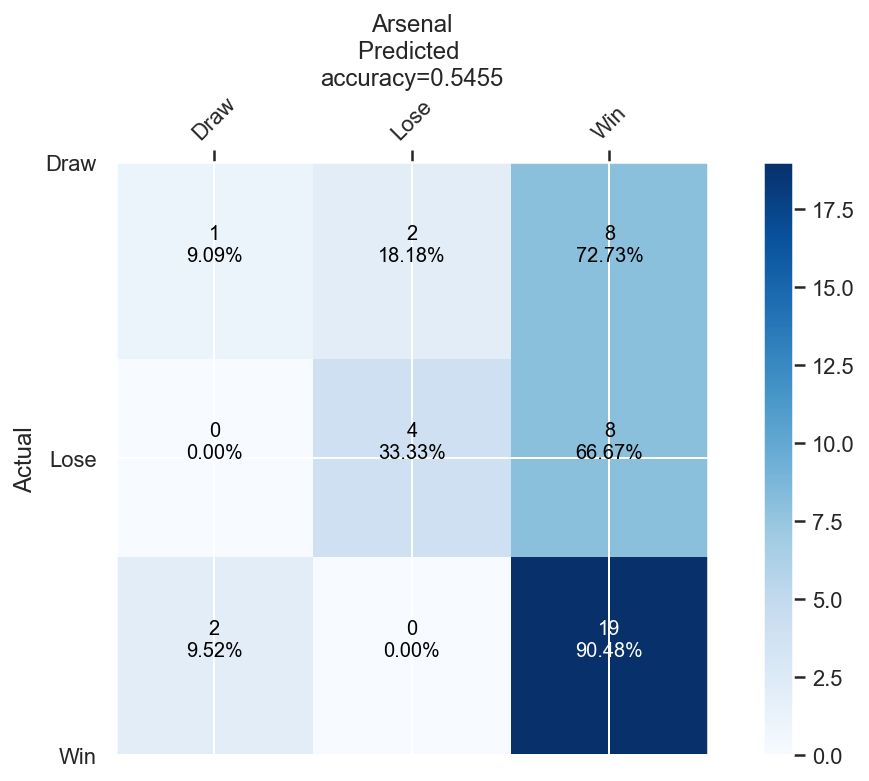

skip Bournemouth
skip Brighton
LogisticRegression: Burnley validation accuracy are: 30.434782608695656
LogisticRegression: Burnley test accuracy are: 27.27272727272727


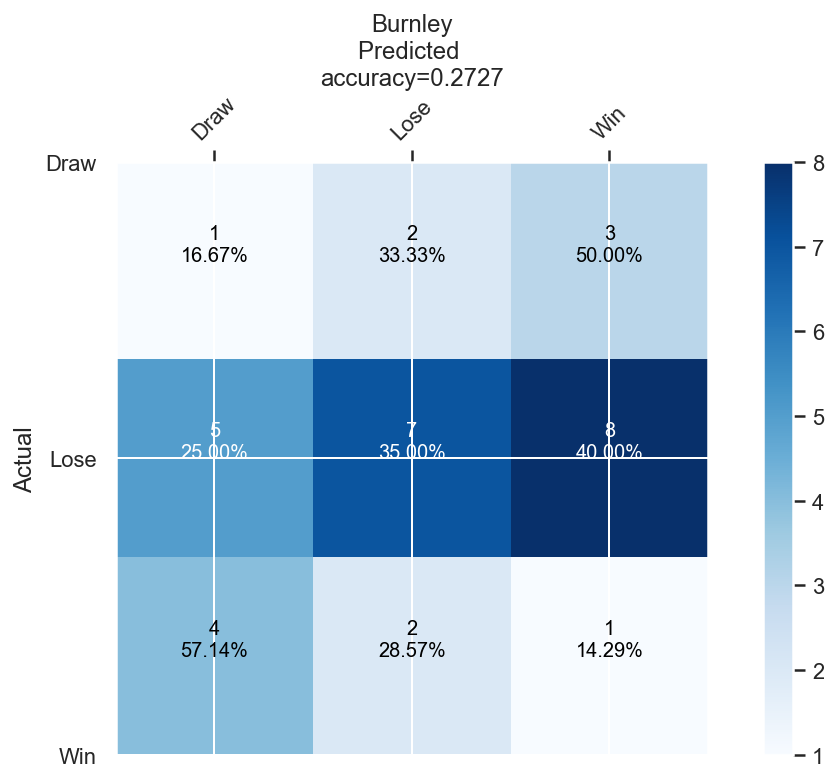

skip Cardiff
LogisticRegression: Chelsea validation accuracy are: 51.515151515151516
LogisticRegression: Chelsea test accuracy are: 44.18604651162791


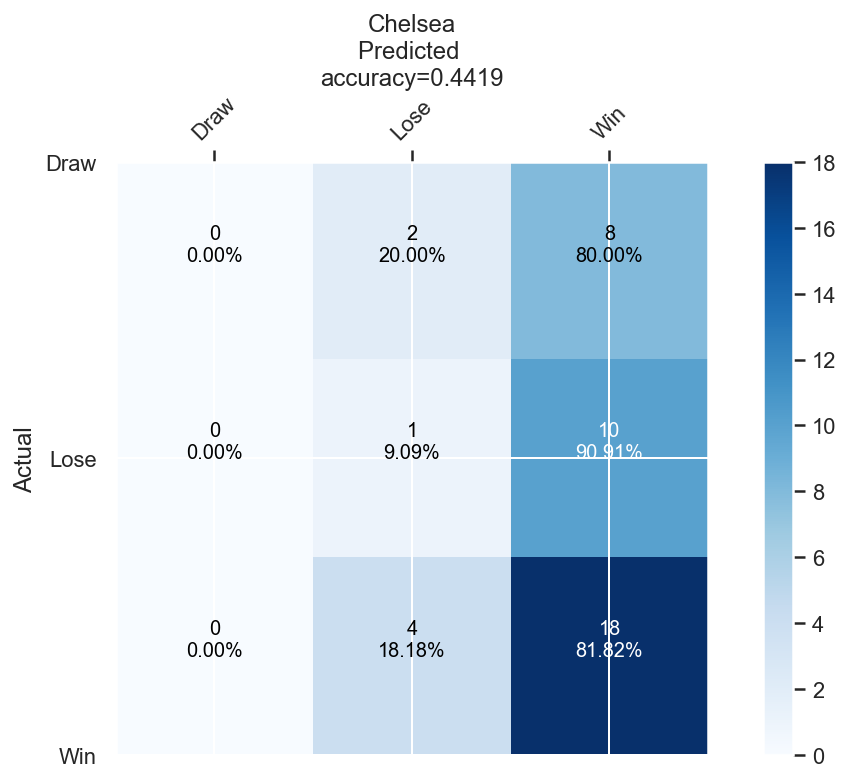

LogisticRegression: Crystal Palace validation accuracy are: 25.806451612903224
LogisticRegression: Crystal Palace test accuracy are: 50.0


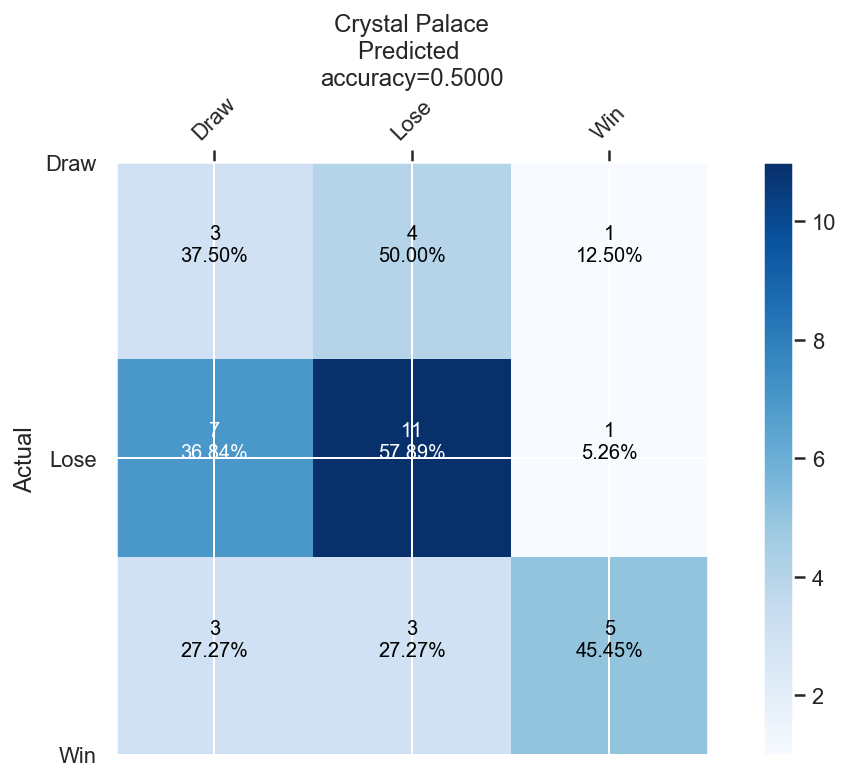

LogisticRegression: Everton validation accuracy are: 45.45454545454545
LogisticRegression: Everton test accuracy are: 46.51162790697674


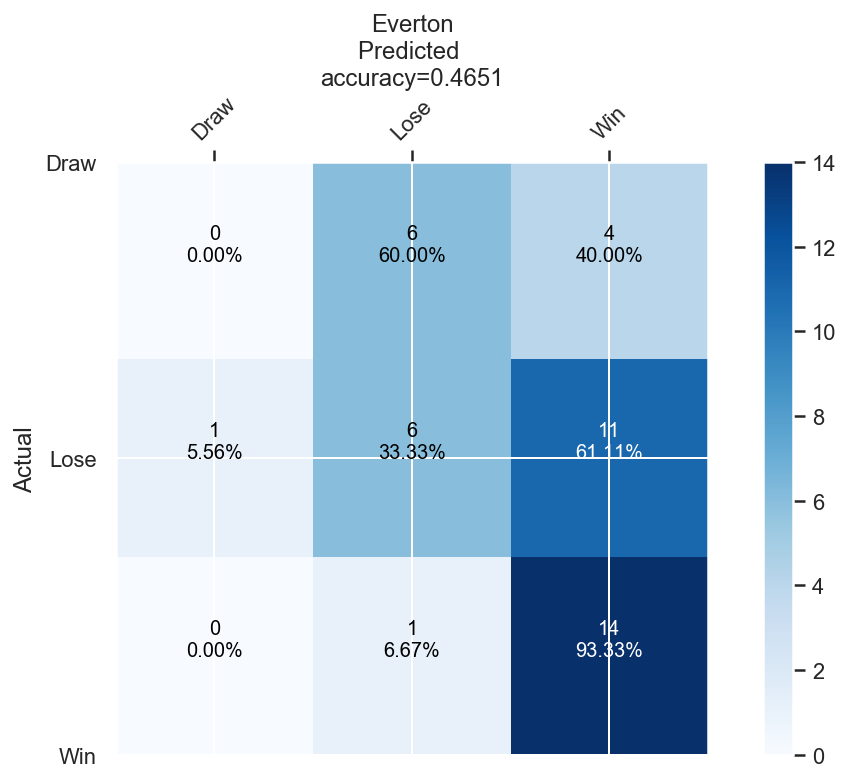

skip Fulham
skip Huddersfield
LogisticRegression: Leicester validation accuracy are: 46.666666666666664
LogisticRegression: Leicester test accuracy are: 42.10526315789473


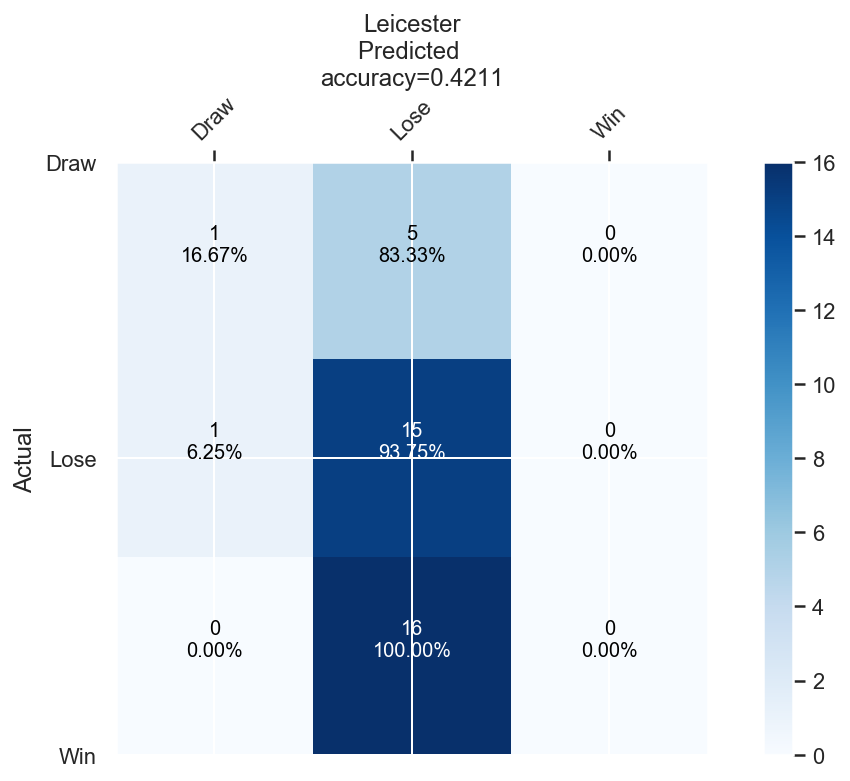

LogisticRegression: Liverpool validation accuracy are: 57.57575757575758
LogisticRegression: Liverpool test accuracy are: 77.27272727272727


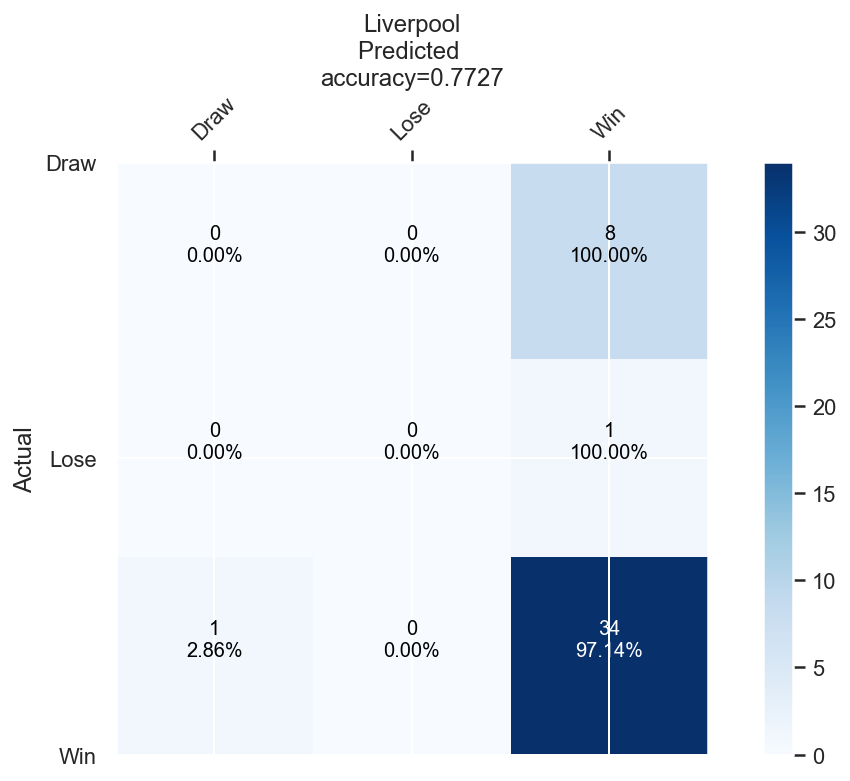

LogisticRegression: Man City validation accuracy are: 57.57575757575758
LogisticRegression: Man City test accuracy are: 61.36363636363637


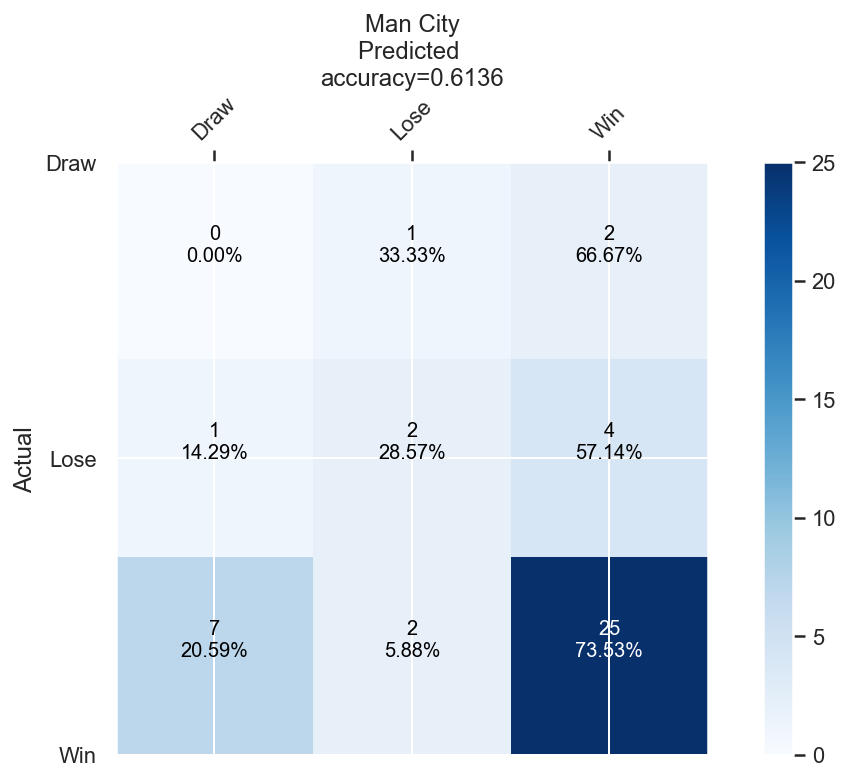

LogisticRegression: Man United validation accuracy are: 42.42424242424242
LogisticRegression: Man United test accuracy are: 44.18604651162791


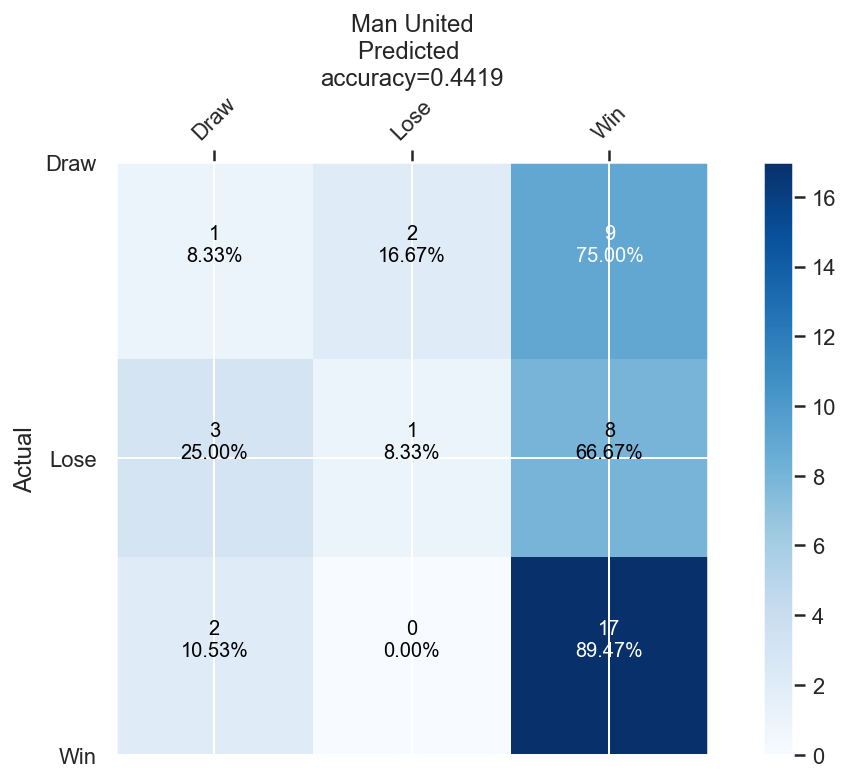

LogisticRegression: Newcastle validation accuracy are: 46.42857142857143
LogisticRegression: Newcastle test accuracy are: 48.78048780487805


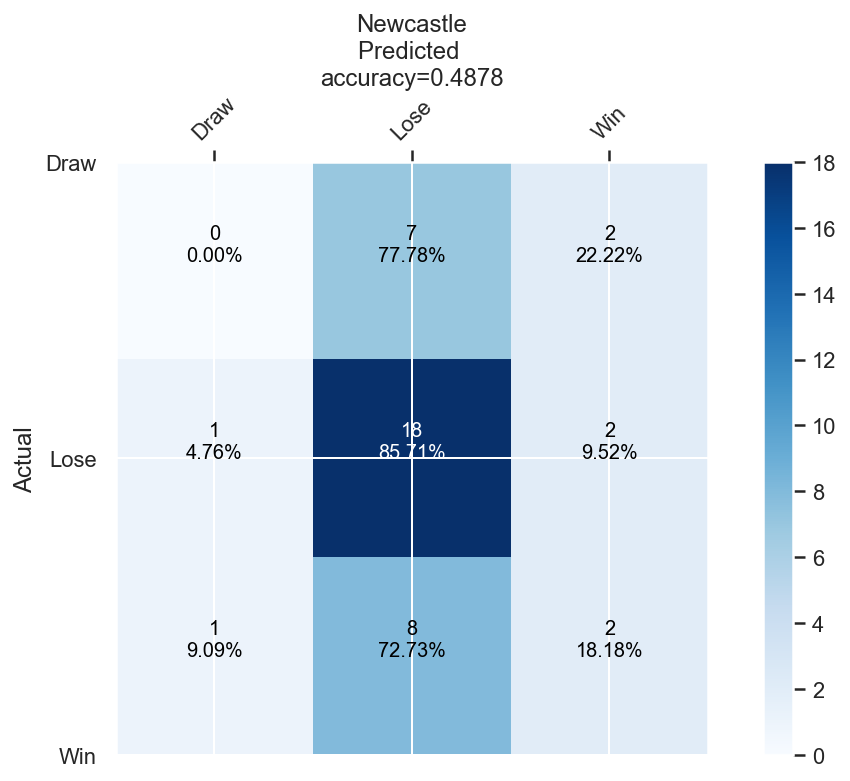

LogisticRegression: Southampton validation accuracy are: 22.58064516129032
LogisticRegression: Southampton test accuracy are: 30.76923076923077


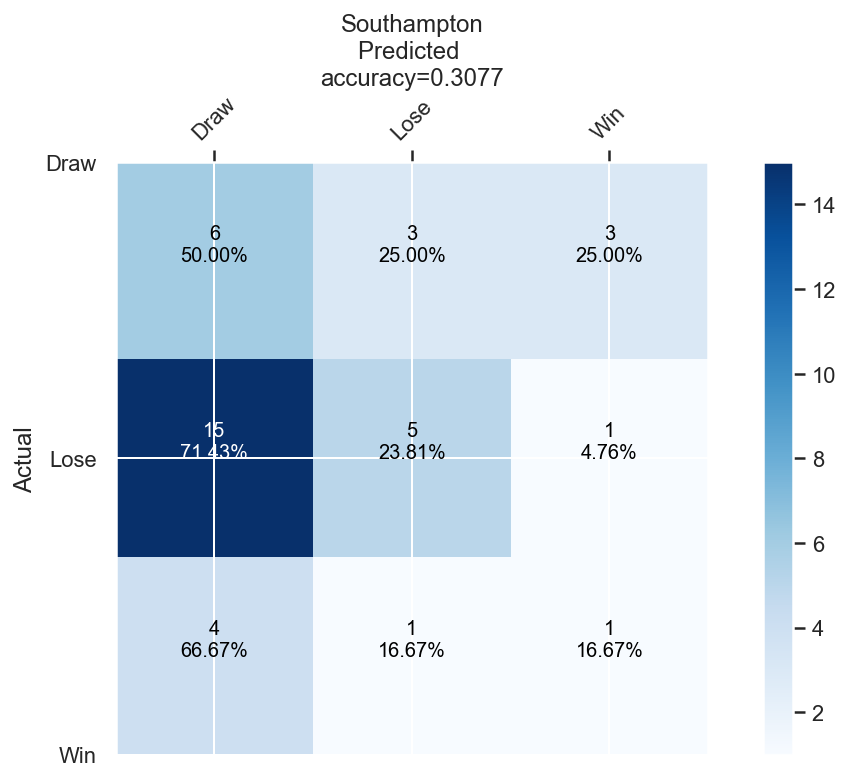

skip Stoke
skip Swansea
LogisticRegression: Tottenham validation accuracy are: 63.63636363636363
LogisticRegression: Tottenham test accuracy are: 58.139534883720934


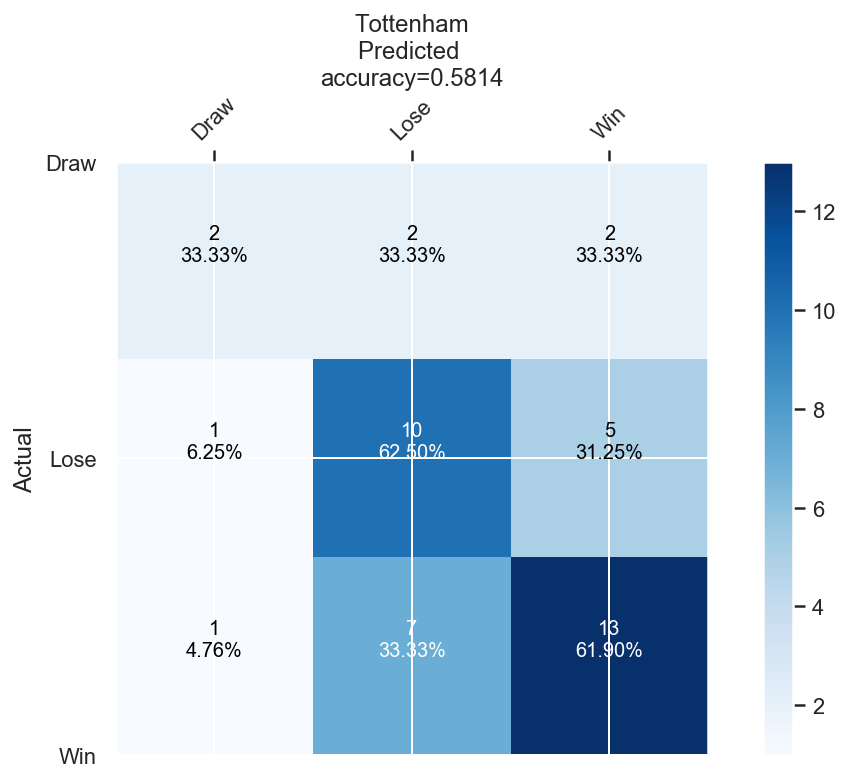

LogisticRegression: Watford validation accuracy are: 33.33333333333333
LogisticRegression: Watford test accuracy are: 33.33333333333333


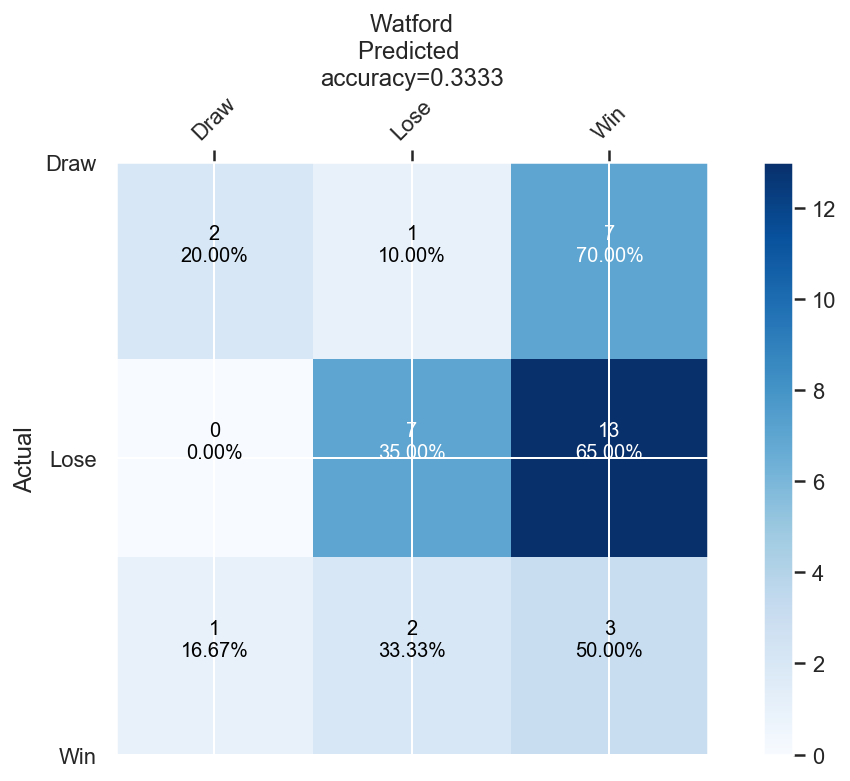

skip West Brom
LogisticRegression: West Ham validation accuracy are: 42.42424242424242
LogisticRegression: West Ham test accuracy are: 45.23809523809524


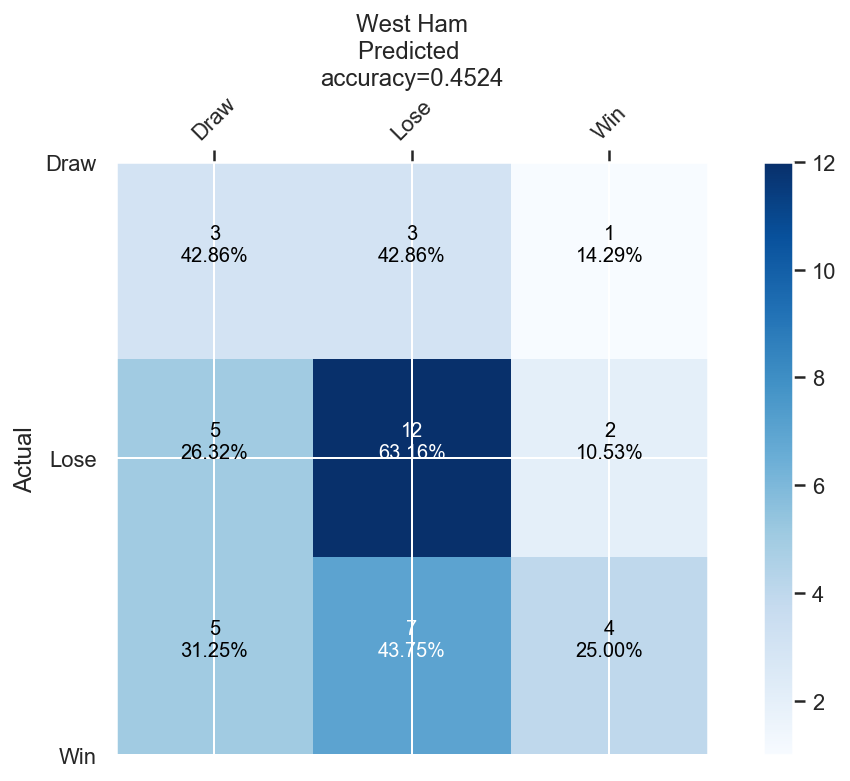

skip Wolves


In [30]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0].drop(['Team'], axis=1)
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=10000)
    lr.fit(x_train, y_train)
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    matches = df[df.index.isin(np.append(y_validate.index, y_test.index))]
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate.append(y_test),
            'Opponent': np.where(matches['HomeTeam'] == team, matches['AwayTeam'], matches['HomeTeam']),
            'HomeMatch': matches['HomeTeam'] == team
        },
        index=np.append(y_validate.index, y_test.index)
    )
    
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
        cm = confusion_matrix(y_test, y_test_pred, labels=classes)
        plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    


In [31]:
# for key, groupByPredictor in total.groupby('predictor'):
#     print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)
print(f"Overall accuracy is ", accuracy_score(total['Actual'], total['Predict'])*100)

Overall accuracy is  46.9061876247505


Pooled data

In [32]:
X = df_allteam.drop(['Team'], axis=1)
Y = df_allteam_y
# split data into train - validate - test sets
x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
x_test = X[(X['Year'] >= test_year)]
y_test = Y[(X['Year'] >= test_year)]

In [33]:
lr_pool = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=10000)
lr_pool.fit(x_train, y_train)
y_validate_pred = lr_pool.predict(x_validate)
y_test_pred = lr_pool.predict(x_test)

In [34]:
accuracy_score(y_validate, y_validate_pred)

0.55

In [35]:
accuracy_score(y_test, y_test_pred)

0.558282208588957

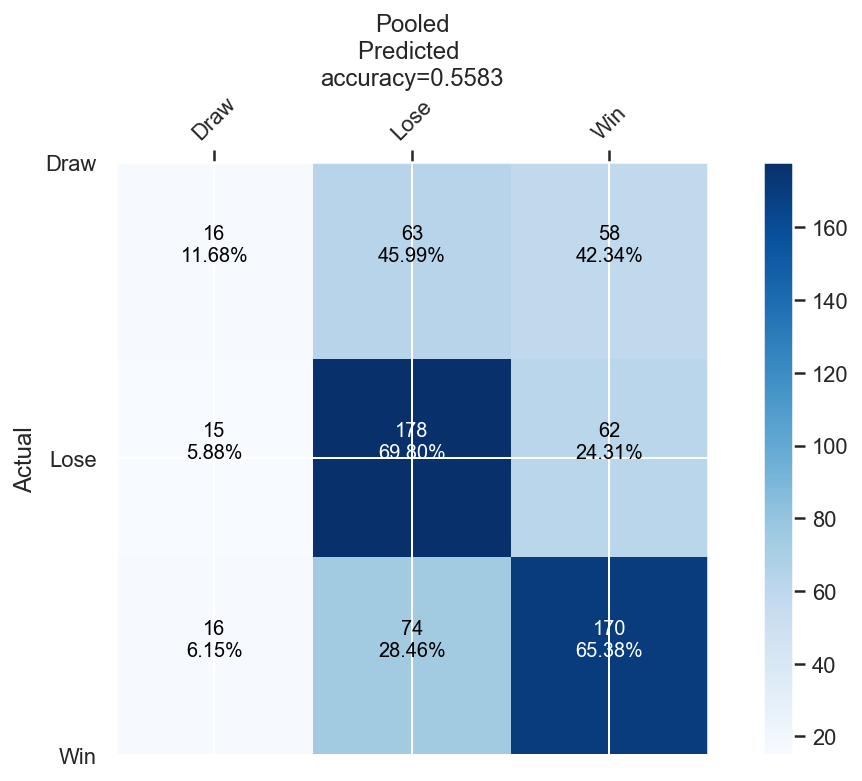

In [36]:
cm = confusion_matrix(y_test, y_test_pred, labels=classes)
plot_confusion_matrix(cm, classes, title='Pooled')

In [37]:
for team in teams:
    
    X = teams[team][0].drop(['Team'], axis=1)
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    y_validate_pred = lr_pool.predict(x_validate)
    y_test_pred = lr_pool.predict(x_test)
    print(f"{k}: {team} pooled validation accuracy are: {accuracy_score(y_validate, y_validate_pred)}")
    print(f"{k}: {team} pooled test accuracy are: {accuracy_score(y_test, y_test_pred)}")
    
    lr = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=10000)
    lr.fit(x_train, y_train)
    y_validate_pred = lr.predict(x_validate)
    y_test_pred = lr.predict(x_test)
    print(f"{k}: {team} private validation accuracy are: {accuracy_score(y_validate, y_validate_pred)}")
    print(f"{k}: {team} private test accuracy are: {accuracy_score(y_test, y_test_pred)}")

LogisticRegression: Arsenal pooled validation accuracy are: 0.6060606060606061
LogisticRegression: Arsenal pooled test accuracy are: 0.6136363636363636
LogisticRegression: Arsenal private validation accuracy are: 0.5757575757575758
LogisticRegression: Arsenal private test accuracy are: 0.5454545454545454
skip Bournemouth
skip Brighton
LogisticRegression: Burnley pooled validation accuracy are: 0.4782608695652174
LogisticRegression: Burnley pooled test accuracy are: 0.6060606060606061
LogisticRegression: Burnley private validation accuracy are: 0.30434782608695654
LogisticRegression: Burnley private test accuracy are: 0.2727272727272727
skip Cardiff
LogisticRegression: Chelsea pooled validation accuracy are: 0.5454545454545454
LogisticRegression: Chelsea pooled test accuracy are: 0.5813953488372093
LogisticRegression: Chelsea private validation accuracy are: 0.5151515151515151
LogisticRegression: Chelsea private test accuracy are: 0.4418604651162791
LogisticRegression: Crystal Palace po

In [38]:
# data = total[(total['Year'] == test_year) & (total['Team'].isin(['Bournemouth'])) & (total['Predict'] == 'Win')]
# print(data)
# print(f"Top accuracy is ", accuracy_score(data['Actual'], data['Predict'])*100)

In [39]:
total

,Year,Team,Predict,Actual,Opponent,HomeMatch
4561,2017,Arsenal,Win,Win,Leicester,True
4576,2017,Arsenal,Win,Lose,Stoke,False
4588,2017,Arsenal,Win,Lose,Liverpool,False
4609,2017,Arsenal,Lose,Draw,Chelsea,False
4620,2017,Arsenal,Win,Win,West Brom,True
...,...,...,...,...,...,...
5396,2019,West Ham,Win,Lose,Crystal Palace,True
5401,2019,West Ham,Lose,Lose,Everton,False
5427,2019,West Ham,Win,Lose,Newcastle,True
5433,2019,West Ham,Lose,Lose,Burnley,False


In [40]:
# %matplotlib inline
# import seaborn as sns
# sns.set()

In [41]:
arsenal = pd.DataFrame(teams['Arsenal'][0])
arsenal = arsenal[(arsenal['Year'] >= validate_year) | (arsenal['Year'] >= test_year)]
arsenal['Actual'] = teams['Arsenal'][1]['Result']
i = total[total.index.isin(arsenal.index)]
arsenal.loc[i.index, 'Predict'] = i['Predict']
arsenal.loc[i.index, 'Team'] = 'Arsenal'
arsenal

KeyError: 'Result'

In [42]:
# sns.set()
sns.countplot(data=arsenal,
              x='Predict', order=['Win', 'Draw', 'Lose'])

ValueError: Could not interpret input 'Predict'

In [43]:
# sns.set()
sns.countplot(data=arsenal,
              x='Actual', order=['Win', 'Draw', 'Lose'])

ValueError: Could not interpret input 'Actual'

C:\Users\vacha\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


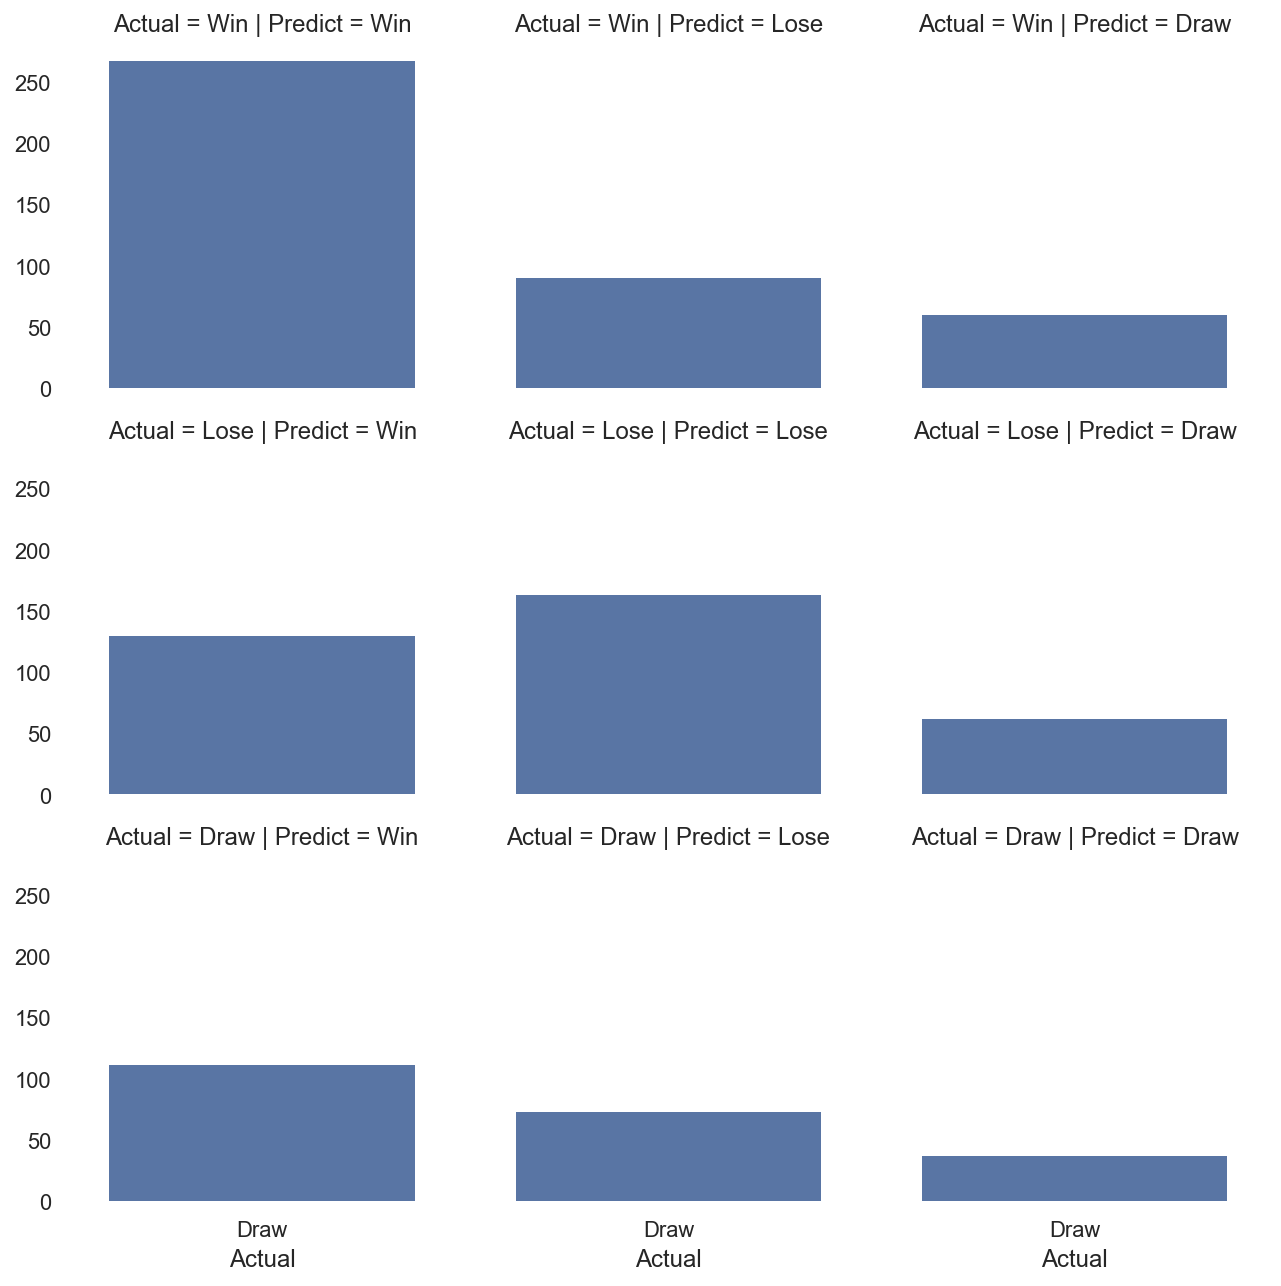

In [44]:
g = sns.FacetGrid(data=total, col="Predict", row="Actual")
g = g.map(sns.countplot, "Actual")

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# sns.set()
g = sns.PairGrid(total,
                x_vars=['Actual', 'Predict'],
                y_vars=['B365Diff'])
g.fig.set_size_inches(15,15)
g = g.map(plt.scatter)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
sns.catplot(x='Predict', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose'],kind="swarm").fig.set_size_inches(8,8)
sns.catplot(x='Actual', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose'], kind="swarm").fig.set_size_inches(8,8)

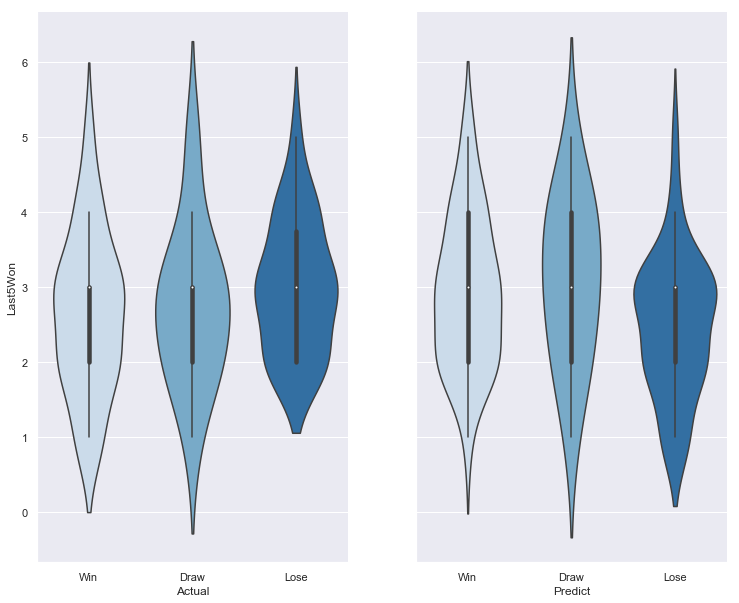

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
g = sns.PairGrid(arsenal,
                x_vars=['Actual', 'Predict'],
                y_vars=['Last5Won'])
g.map(sns.violinplot, order=['Win', 'Draw', 'Lose'], palette="Blues").fig.set_size_inches(12,12)
# sns.violinplot(x='Predict', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose']).fig.set_size_inches(8,8)
# sns.violinplot(x='Actual', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose']).fig.set_size_inches(8,8)

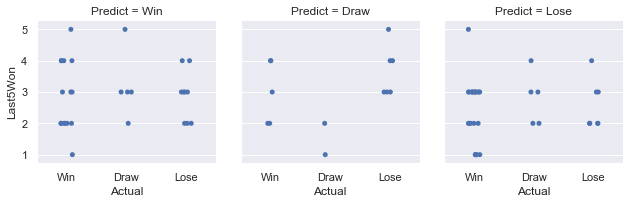

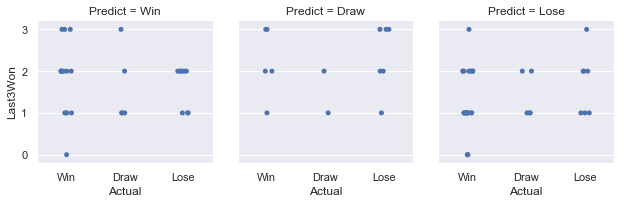

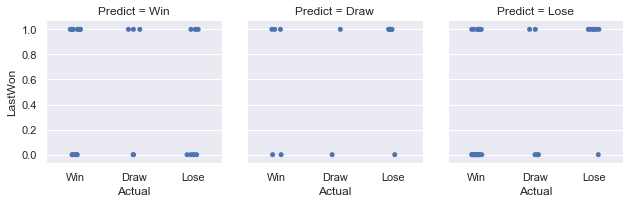

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'Last5Won', order=['Win', 'Draw', 'Lose'])
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'Last3Won', order=['Win', 'Draw', 'Lose'])
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'LastWon', order=['Win', 'Draw', 'Lose'])

In [18]:
chart_data = {}
chart_data_all = None
for team, dataset in teams.items():
#     if team == 'Everton':
#         print (dataset[0])
    chart_data_team = pd.DataFrame(dataset[0])
    chart_data_team = chart_data_team[(chart_data_team['Year'] >= validate_year) | (chart_data_team['Year'] >= test_year)]
    chart_data_team['Actual'] = dataset[1]['Result']
#     if team == 'Everton':
#         print(chart_data_team)
#         print(chart_data_team.loc[chart_data_team['Year'] == 2017, ['Year', 'Team']].count())
    i = total[(total.index.isin(chart_data_team.index)) & (total['Team'] == team)]
#     if team == 'Everton':
#         print(i)
    chart_data_team.loc[i.index, 'Predict'] = i['Predict']
    chart_data_team['Point'] = np.where(chart_data_team['Actual'] == 'Win', 3,
                                 np.where(chart_data_team['Actual'] == 'Draw', 1, 0)
                                  )
    chart_data_team['PointPredict'] = np.where(chart_data_team['Predict'] == 'Win', 3,
                                 np.where(chart_data_team['Predict'] == 'Draw', 1, 0)
                                  )
    for key, groupByYear in chart_data_team.groupby('Year'):
        chart_data_team.loc[groupByYear.index, 'MatchNo'] = range(1,len(groupByYear['Actual'])+1)
        chart_data_team.loc[groupByYear.index, 'TotalPoints'] = np.nancumsum(groupByYear['Point'])
        chart_data_team.loc[groupByYear.index, 'TotalPointsPredict'] = np.nancumsum(groupByYear['PointPredict'])
    if team == 'Everton':
#         print(dataset[0].loc[dataset[0]['Year'] == 2017, ['Year', 'Predict']])
        print(chart_data_team.loc[chart_data_team['Year'] == 2017, ['Year','Predict']])
    chart_data_team['Team'] = team
    chart_data[team] = chart_data_team
    if chart_data_all is None:
        chart_data_all = chart_data_team
    else:
        chart_data_all = chart_data_all.append(chart_data_team, ignore_index=True, sort=False)
chart_data_all

      Year Predict
4565  2017     Win
4580  2017    Lose
4587  2017    Lose
4593  2017    Lose
4610  2017    Lose
4612  2017     Win
4629  2017     Win
4638  2017     Win
4649  2017    Lose
4659  2017    Lose
4668  2017     Win
4674  2017    Draw
4690  2017    Lose
4698  2017     Win
4704  2017     Win
4718  2017    Draw
4726  2017     Win
4740  2017    Draw
4744  2017    Lose
4758  2017    Draw
4761  2017    Lose
4772  2017    Lose
4785  2017    Lose
4794  2017     Win
4805  2017     Win
4811  2017    Lose
4821  2017    Draw
4836  2017    Draw
4841  2017     Win
4852  2017     Win
4864  2017     Win
4867  2017    Lose
4877  2017    Draw
4890  2017    Draw
4904  2017     Win
4907  2017    Draw
4917  2017     Win
4940  2017     Win


,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,...,LastWon,LastDraw,Actual,Predict,Point,PointPredict,MatchNo,TotalPoints,TotalPointsPredict,Team
0,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,...,1.0,0.0,Lose,Win,0,3,1.0,0.0,3.0,Arsenal
1,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,Draw,Win,1,3,2.0,1.0,6.0,Arsenal
2,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,1.0,Win,Win,3,3,3.0,4.0,9.0,Arsenal
3,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,Win,Win,3,3,4.0,7.0,12.0,Arsenal
4,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,5.0,10.0,15.0,Arsenal
5,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,Win,Draw,3,1,6.0,13.0,16.0,Arsenal
6,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,7.0,16.0,19.0,Arsenal
7,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,8.0,19.0,22.0,Arsenal
8,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,...,1.0,0.0,Draw,Win,1,3,9.0,20.0,25.0,Arsenal
9,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,...,0.0,1.0,Win,Win,3,3,10.0,23.0,28.0,Arsenal


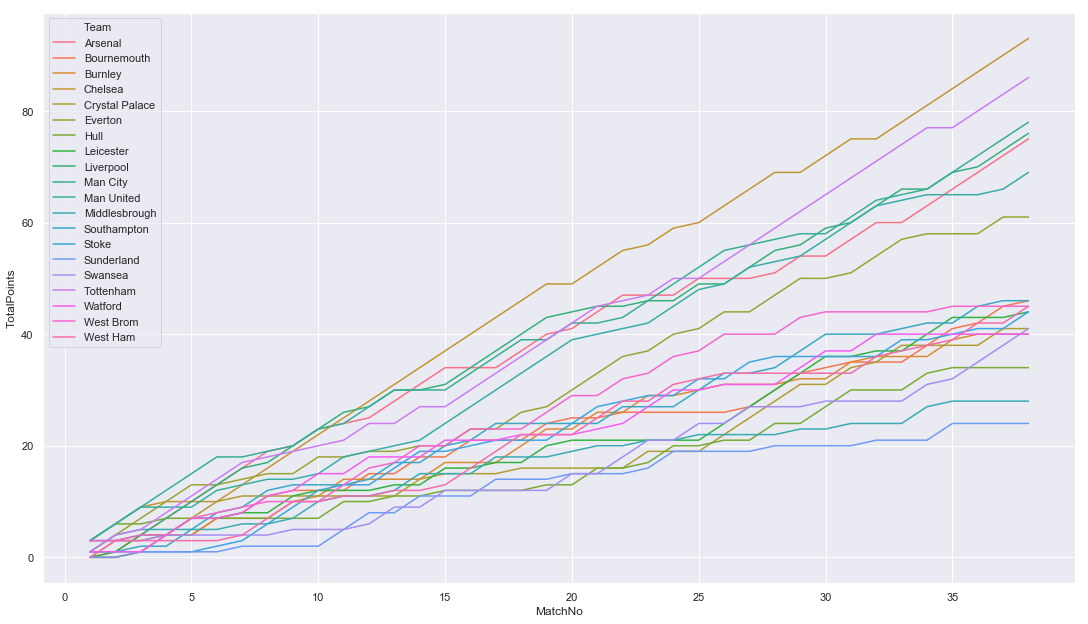

In [19]:
sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2016], x='MatchNo', y='TotalPoints', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

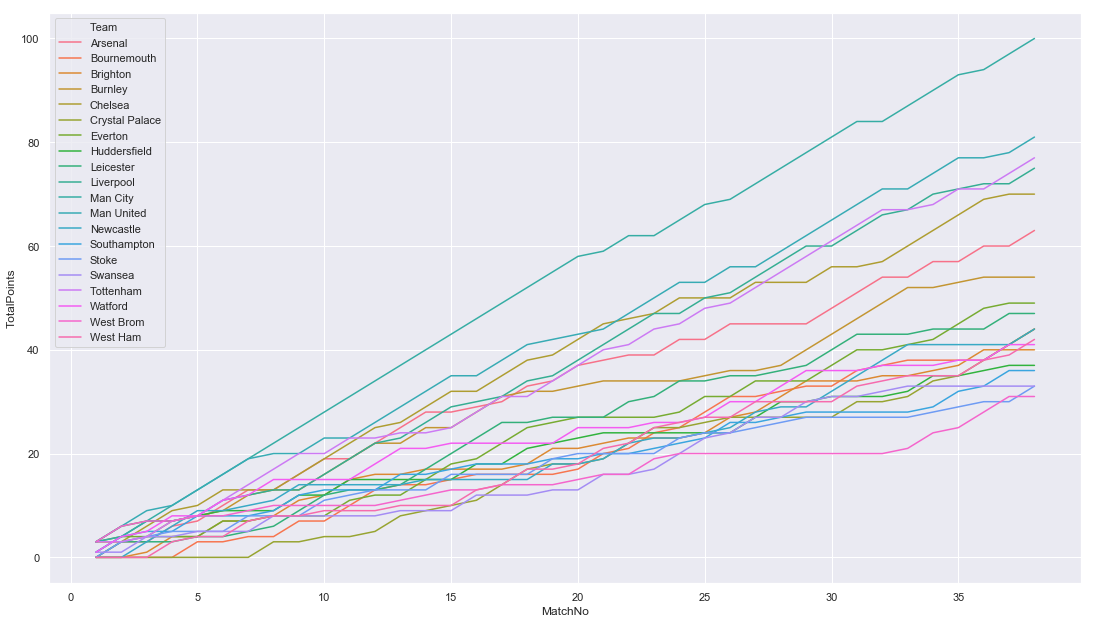

In [20]:
sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2017], x='MatchNo', y='TotalPoints', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

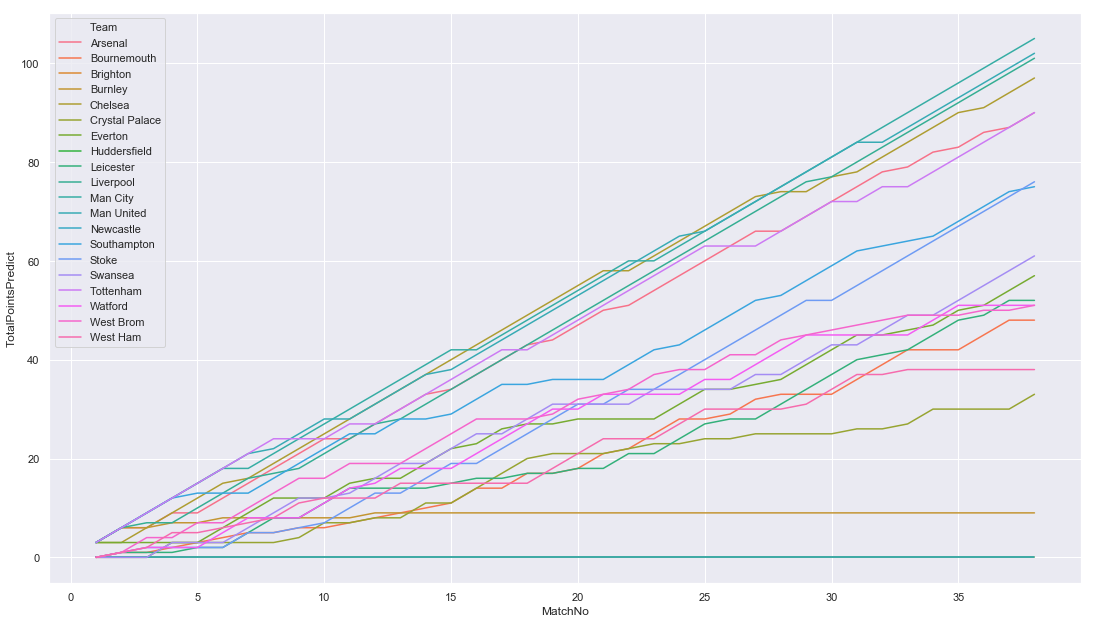

In [21]:

sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2017], x='MatchNo', y='TotalPointsPredict', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

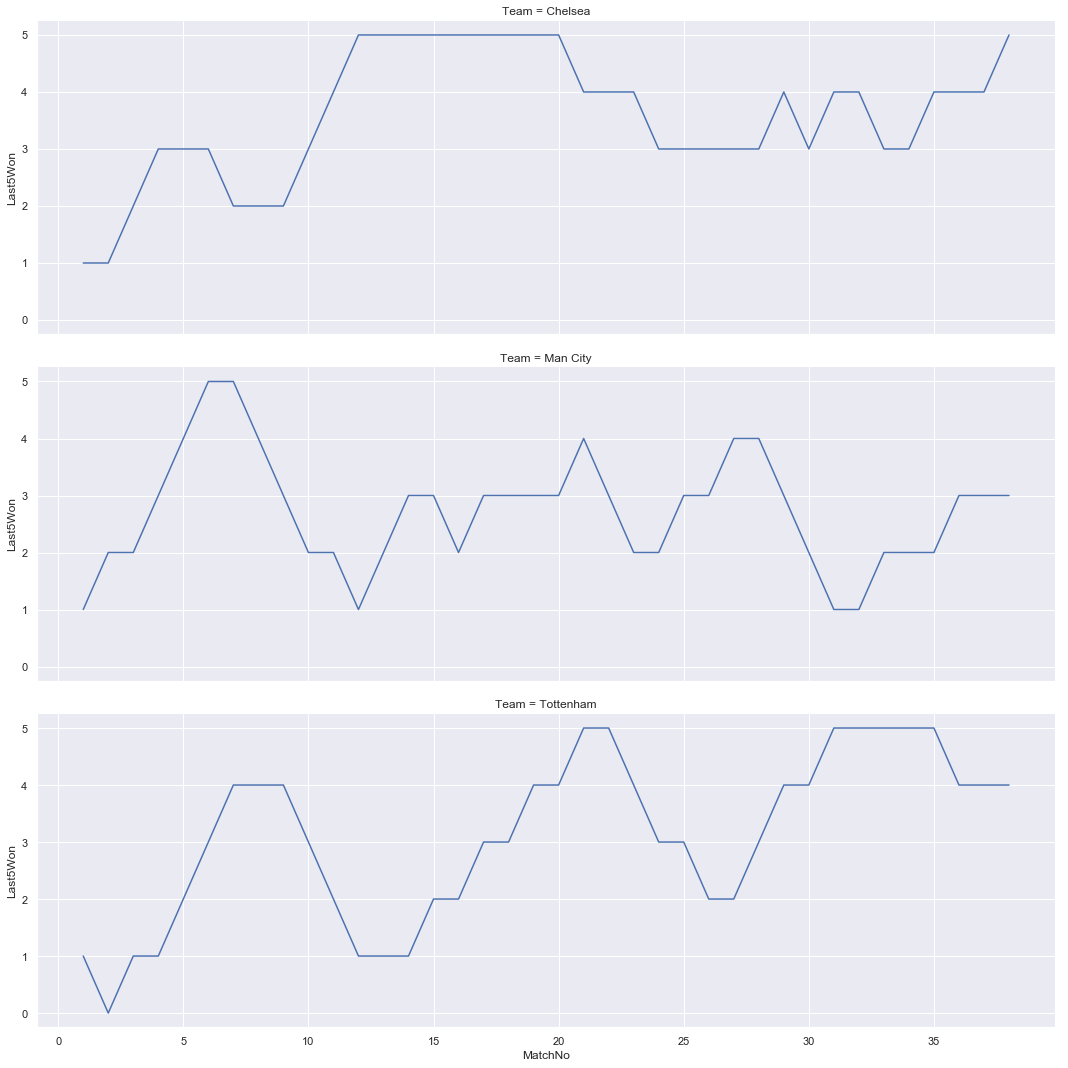

In [22]:
data = chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City'])]
sns.set()
g = sns.FacetGrid(data,
                row='Team',
                )
g.fig.set_size_inches(15,15)
g = g.map(sns.lineplot, 'MatchNo', 'Last5Won')

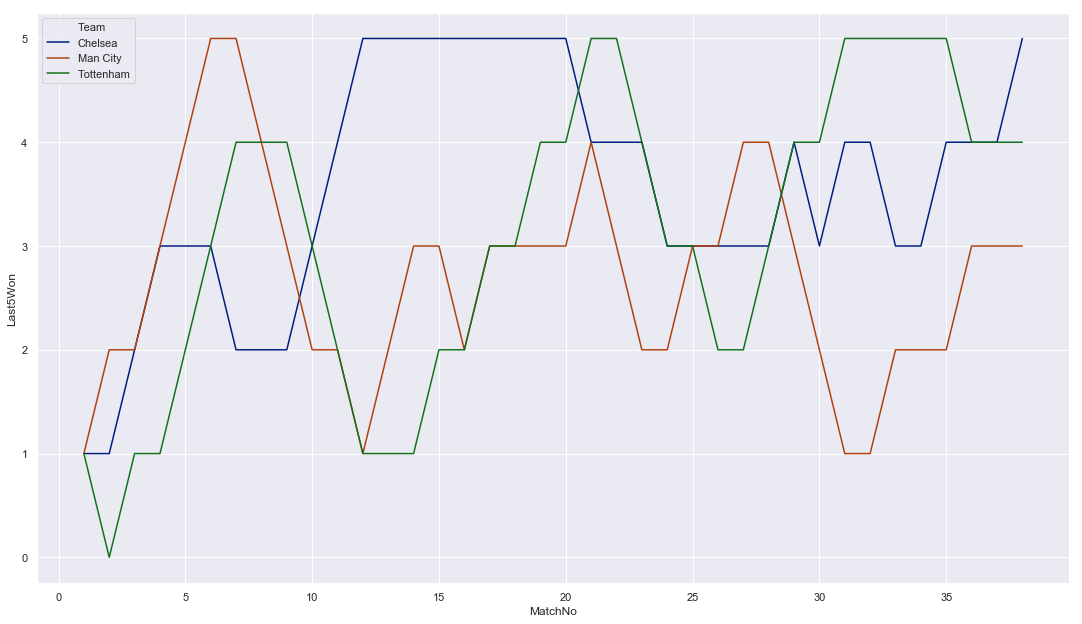

In [23]:
# chelsea = chart_data['Chelsea']
# print(chelsea[chelsea['Year'] == 2016][['MatchNo', 'Last5Won', 'Year']])
sns.set()
g = sns.lineplot(x='MatchNo', y='Last5Won', hue='Team', 
                 palette=sns.color_palette('dark', 3),
#                  palette=sns.color_palette([chelsea_blue, mancity_blue, tottenham_blue]),
                 data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City'])])
#                  data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City', 'Liverpool', 'Arsenal', 'Man United'])])
g.figure.set_size_inches(18.5, 10.5)

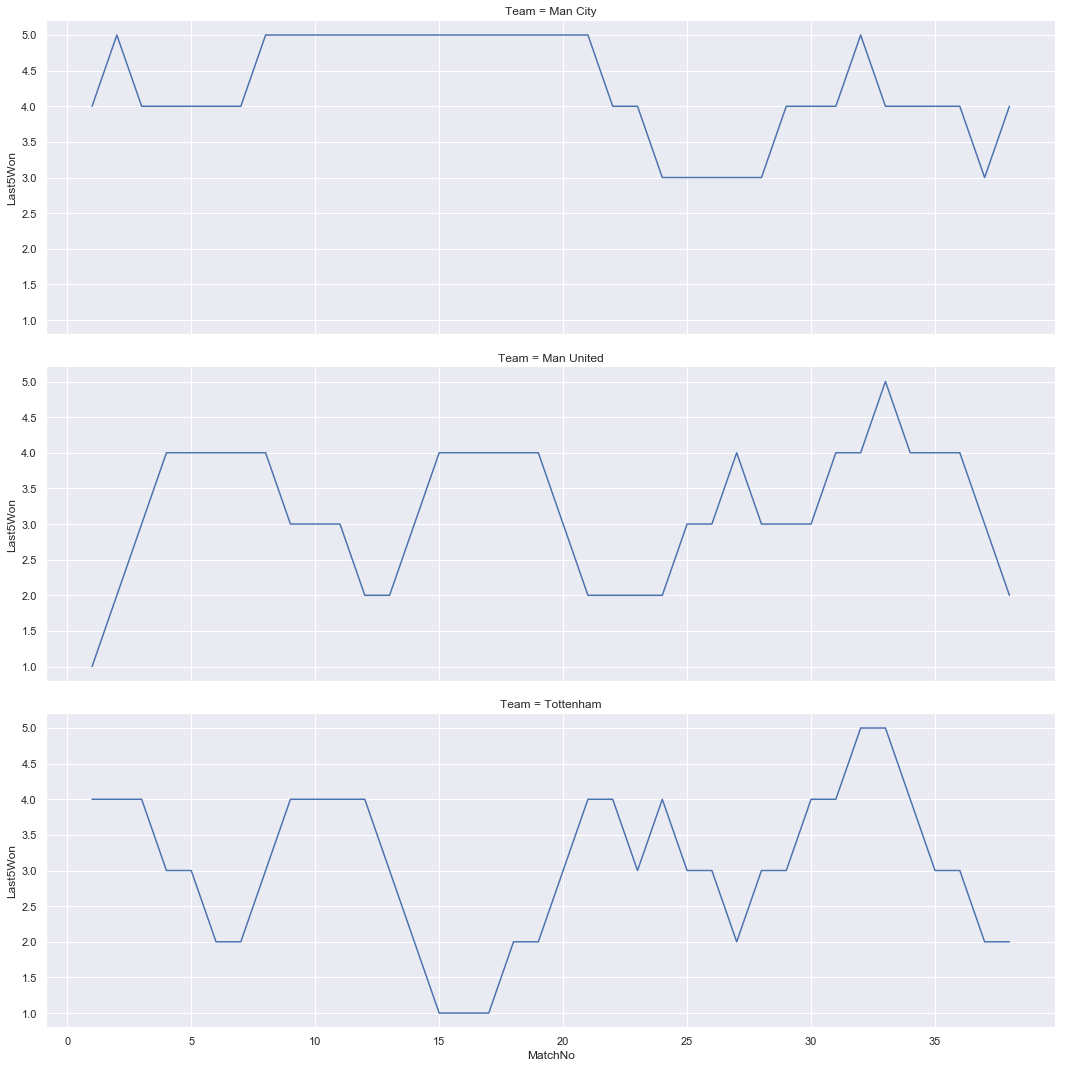

In [24]:
data = chart_data_all[(chart_data_all['Year'] == 2017) & chart_data_all['Team'].isin(['Man City', 'Man United', 'Tottenham'])]
sns.set()
g = sns.FacetGrid(data,
                row='Team',
                )
g.fig.set_size_inches(15,15)
g = g.map(sns.lineplot, 'MatchNo', 'Last5Won')

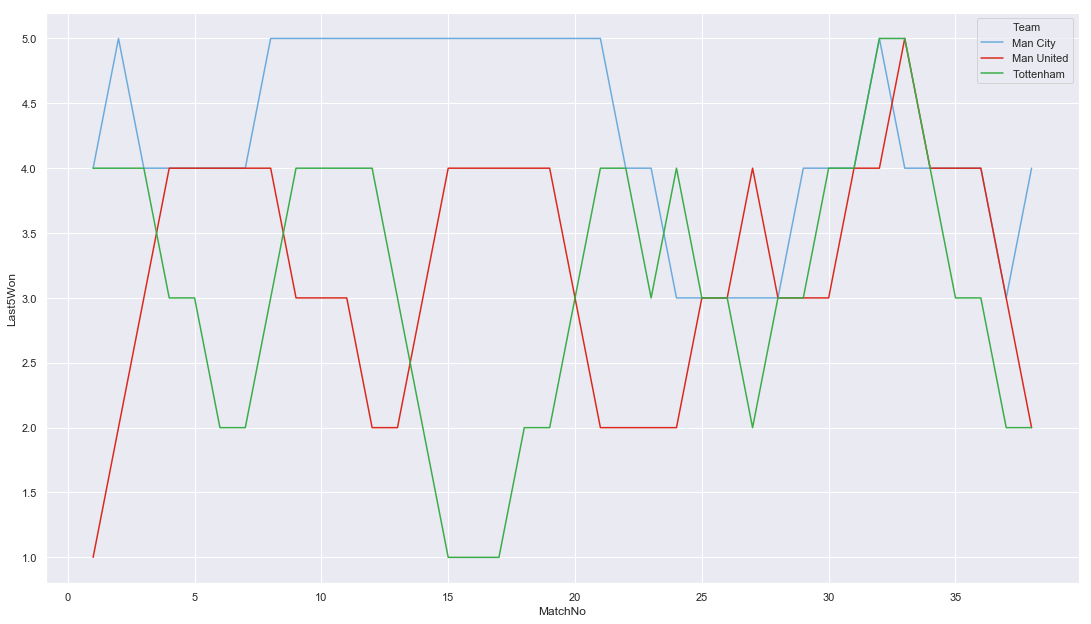

In [25]:
sns.set()
g = sns.lineplot(x='MatchNo', y='Last5Won', hue='Team', 
#                  palette=sns.color_palette('dark', 3),
                 palette=sns.color_palette([mancity_blue, manutd_red, sns.xkcd_rgb["medium green"]]),
                 data=chart_data_all[(chart_data_all['Year'] == 2017) & chart_data_all['Team'].isin(['Man City', 'Man United', 'Tottenham'])])
#                  data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City', 'Liverpool', 'Arsenal', 'Man United'])])
g.figure.set_size_inches(18.5, 10.5)

/Users/vachara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


     Year  HomeMatch  B365Say  B365Diff  Last5AgainstThisOpponentWon  \
456  2017       True        1      4.05                          2.0   
461  2017       True        1      4.10                          0.0   
462  2017       True        1      4.08                          4.0   
463  2017      False        0     -0.85                          0.0   
466  2017       True        1      1.40                          2.0   
469  2017       True        1      0.92                          2.0   
470  2017       True        1      3.78                          0.0   
472  2017      False        0      0.86                          4.0   
479  2017       True        1      1.86                          3.0   
480  2017       True        0      0.38                          2.0   
484  2017      False       -1     -0.79                          3.0   
485  2017       True        1      1.69                          0.0   
486  2017      False        0      0.60                         

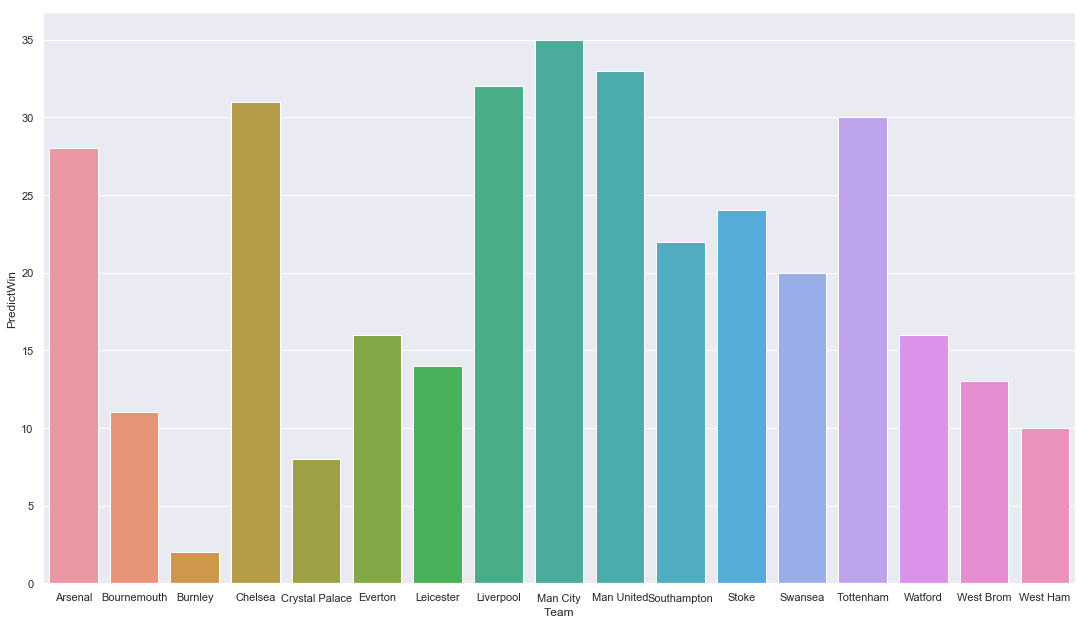

In [26]:
data = chart_data_all[(chart_data_all['Year'] == 2017)]
# print(data.loc[data['Team'] == 'Everton', ['Predict', 'Actual']].groupby('Predict').count())
win_count = data[data['Predict'] == 'Win'].groupby(['Team'])['Predict'].agg({'PredictWin':'count'})
win_count['Team'] = win_count.index
print(data[(data['Predict'] == 'Win') & (data['Team'] == 'Everton')])
# win_count['Team']
print(win_count)
sns.set()
g = sns.barplot(x='Team', y='PredictWin', data=win_count)
g.figure.set_size_inches(18.5, 10.5)

/Users/vachara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


    Actual
114   Lose
115   Lose
116   Lose
117   Lose
118    Win
119   Lose
120   Draw
121   Lose
122    Win
123   Lose
124    Win
125    Win
126   Draw
127   Lose
128   Draw
129   Draw
130   Lose
131   Lose
132   Lose
133   Draw
134    Win
135   Draw
136    Win
137   Draw
138    Win
139    Win
140   Lose
141   Draw
142   Draw
143   Lose
144    Win
145   Draw
146   Draw
147   Lose
148   Lose
149   Lose
150    Win
151    Win


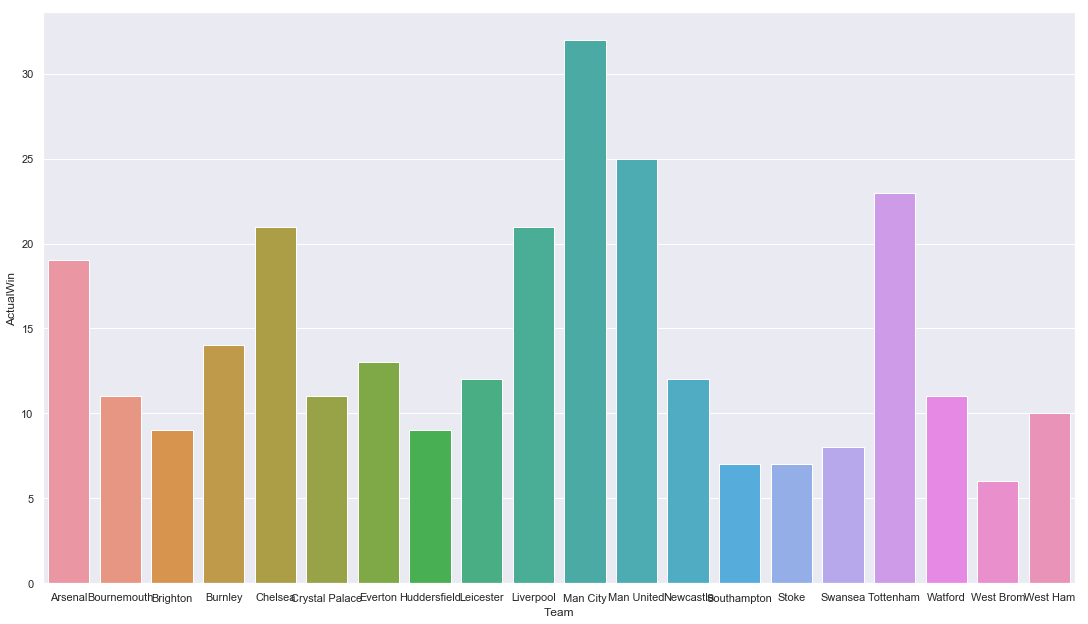

In [51]:
data = chart_data_all[(chart_data_all['Year'] == 2017)]
win_count = data[data['Actual'] == 'Win'].groupby(['Team'])['Actual'].agg({'ActualWin':'count'})
win_count['Team'] = win_count.index
# print(data[(data['Actual'] == 'Win') & (data['Team'] == 'Bournemouth')])
print(data.loc[(data['Team'] == 'Bournemouth'), ['Actual']])
# win_count['Team']
sns.set()
g = sns.barplot(x='Team', y='ActualWin', data=win_count)
g.figure.set_size_inches(18.5, 10.5)

In [28]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights
# ax = sns.heatmap(flights)

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [29]:
data = total[total['Year'] == test_year].sort_values(['Team', 'HomeMatch', 'Opponent'])
data['Correct'] = data['Predict'] == data['Actual']
data['index'] = data.index
del data['Year']
# print(data)
team_names = data['Team'].unique()
team_names.sort()
# print(team_names)
# print(len(team_names))
results = []
i = 0
for team_name in team_names:
    df_team = (df[(df['Year'] == test_year) & (df['HomeTeam'] == team_name)]).sort_values('AwayTeam')
#     print (df_team)
    team_result = []
    j = 0
    for index, match in df_team.iterrows():
        
#         if match['FTHG'] > match['FTAG']:
#             print('win')
#         elif match['FTHG'] < match['FTAG']:
#             print('lose')
#         else:
#             print('draw')
        prediction = data[(data.index == match['index']) & (data['Team'] == match['HomeTeam'])]
#         print(prediction)
        if prediction['Opponent'].values[0] in team_names:
            if i == j:
#                 team_result.append(float('nan'))
                team_result.append(None)
#             team_result.append(prediction['Actual'].values[0])
            act = prediction['Actual'].values[0]
            value = 0
            if act == 'Win':
                value = 1
            elif act == 'Lose':
                value =-1
            team_result.append(value)
            j += 1
    results.append(team_result)
    i += 1
# len(results)
pp = pd.DataFrame(
    data=results,
    columns=team_names,
    index=team_names
)
pp
# fixtures = pd.DataFrame(df[df['Year'] == test_year])
# fixtures['Date'] = pd.to_datetime(fixtures['Date'], dayfirst=True)
# fixtures.sort_values(['Date'], inplace=True)
# winners = np.where(fixtures['FTHG'] > fixtures['FTAG'], fixtures['HomeTeam'], 
#          np.where(fixtures['FTHG'] < fixtures['FTAG'], fixtures['AwayTeam'], ''))
# winners = winners[winners != '']
# winners
# for i, groupByIndex in data.groupby(['Team', 'HomeMatch']):
#     print(groupByIndex)
# foo = pd.Categorical(winners, categories=xxx)
# bar = pd.Categorical(winners, categories=xxx)

# data.groupby('index').apply(lambda x: print(x))
# data
# pd.crosstab(foo, bar)
# foo

,Arsenal,Bournemouth,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man United,Southampton,Stoke,Swansea,Tottenham,Watford,West Brom,West Ham
Arsenal,NaN,1.0,1.0,0.0,1.0,1.0,1.0,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bournemouth,1.0,NaN,-1.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,-1.0,1.0,0.0
Burnley,-1.0,-1.0,NaN,-1.0,1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,-1.0,0.0
Chelsea,0.0,-1.0,-1.0,NaN,1.0,1.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0
Crystal Palace,-1.0,0.0,1.0,1.0,NaN,0.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.0
Everton,-1.0,1.0,-1.0,0.0,1.0,NaN,1.0,0.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,0.0,1.0
Leicester,1.0,0.0,1.0,-1.0,-1.0,1.0,NaN,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Liverpool,1.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
Man City,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Man United,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-1.0,NaN,0.0,1.0,1.0,1.0,1.0,-1.0,1.0


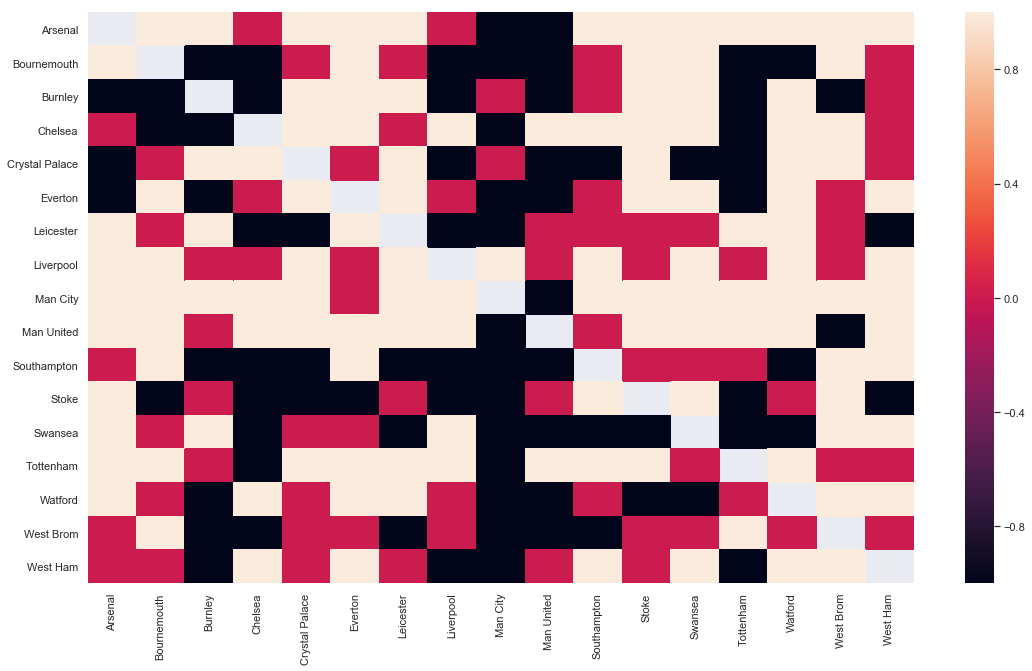

In [30]:
g = sns.heatmap(pp)
g.figure.set_size_inches(18.5, 10.5)

In [31]:
data = total[total['Year'] == test_year].sort_values(['Team', 'HomeMatch', 'Opponent'])
data['Correct'] = data['Predict'] == data['Actual']
data['index'] = data.index
del data['Year']
# print(data)
team_names = data['Team'].unique()
team_names.sort()
results = []
i = 0
for team_name in team_names:
    df_team = (df[(df['Year'] == test_year) & (df['HomeTeam'] == team_name)]).sort_values('AwayTeam')
#     print (df_team)
    team_result = []
    j = 0
    for index, match in df_team.iterrows():
        prediction = data[(data.index == match['index']) & (data['Team'] == match['HomeTeam'])]
#         print(prediction)
        if prediction['Opponent'].values[0] in team_names:
            if i == j:
                team_result.append(None)
            act = prediction['Actual'].values[0]
            pred = prediction['Predict'].values[0]
            value = 0
            if pred == act:
                value = 1
            team_result.append(value)
            j += 1
    results.append(team_result)
    i += 1
# len(results)
pp = pd.DataFrame(
    data=results,
    columns=team_names,
    index=team_names
)
print(pp.sum())
pp

Arsenal            8.0
Bournemouth        8.0
Burnley            4.0
Chelsea            9.0
Crystal Palace     6.0
Everton            9.0
Leicester          7.0
Liverpool          8.0
Man City          11.0
Man United        11.0
Southampton        9.0
Stoke              7.0
Swansea           10.0
Tottenham          9.0
Watford           10.0
West Brom         10.0
West Ham           8.0
dtype: float64


,Arsenal,Bournemouth,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man United,Southampton,Stoke,Swansea,Tottenham,Watford,West Brom,West Ham
Arsenal,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bournemouth,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Burnley,1.0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Chelsea,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
Crystal Palace,1.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
Everton,1.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
Leicester,1.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
Liverpool,0.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
Man City,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Man United,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0


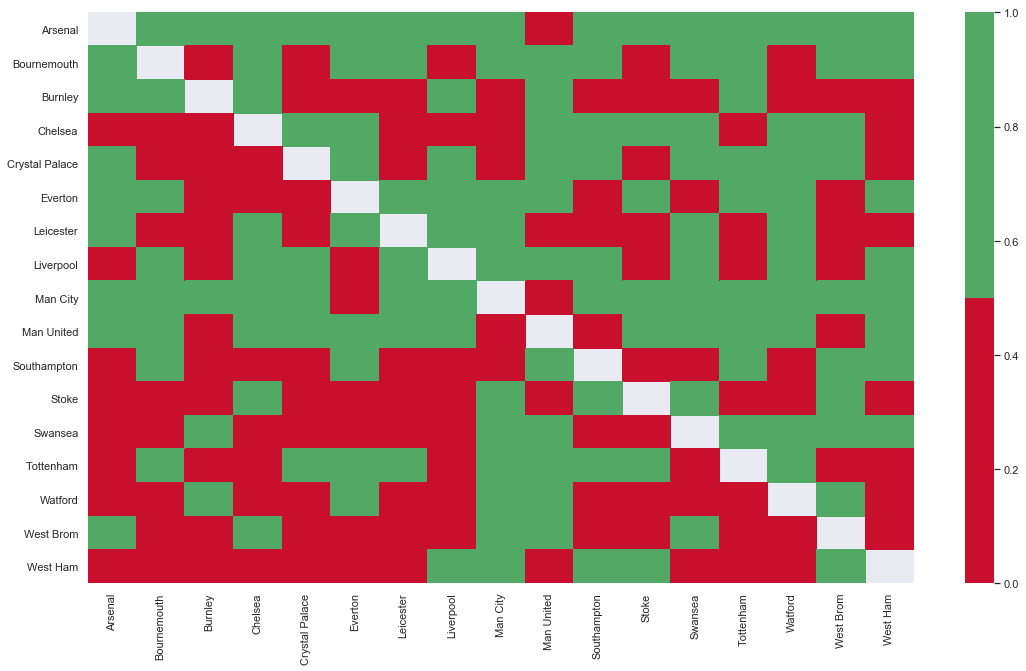

In [32]:
g = sns.heatmap(pp, cmap=[liverpool_red, '#52A966'], cbar=True)
g.figure.set_size_inches(18.5, 10.5)

In [78]:
# fixtures = pd.DataFrame(df[df['Year'] == test_year])
# fixtures = pd.DataFrame(df[df['Year'] == 2019])
fixtures = pd.DataFrame(df[df['Year'] == 2018])
fixtures['Date'] = pd.to_datetime(fixtures['Date'], dayfirst=True)
fixtures.sort_values(['Date'], inplace=True)
# fixtures.dropna(subset=['Year'], inplace=True)
fixtures

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
4941,4941,E0,2018-08-10,Man United,Leicester,2.0,1.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,4942,E0,2018-08-11,Bournemouth,Cardiff,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4943,4943,E0,2018-08-11,Fulham,Crystal Palace,0.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4944,4944,E0,2018-08-11,Huddersfield,Chelsea,0.0,3.0,A,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4945,4945,E0,2018-08-11,Newcastle,Tottenham,1.0,2.0,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,5315,E0,2019-05-12,Leicester,Chelsea,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5316,5316,E0,2019-05-12,Liverpool,Wolves,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5317,5317,E0,2019-05-12,Man United,Cardiff,0.0,2.0,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5318,5318,E0,2019-05-12,Southampton,Huddersfield,1.0,1.0,D,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0].drop(['Team'], axis=1)
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
#     lr = LogisticRegression()
#     lr.fit(x_train, y_train)
    lr = lr_pool
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    y_validate_prob = lr.predict_proba(x_validate)
    y_test_prob = lr.predict_proba(x_test)
#     print(y_validate_prob)
#     print(y_test_prob)
    prob = np.vstack((y_validate_prob, y_test_prob))
#     print(prob)
#     print(prob[:,0])
#     print(np.max(prob, axis=1))
#     print(np.min(prob, axis=1))
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate.append(y_test),
            'DrawProb': prob[:,0],
            'LoseProb': prob[:,1],
            'WinProb': prob[:,2],
            'MaxProb': np.max(prob, axis=1),
            'MinProb': np.min(prob, axis=1)
        },
        index=np.append(y_validate.index, y_test.index)
#         index=pd.MultiIndex.from_tuples(
#             list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
#             names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
#         cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
#         cm = confusion_matrix(y_test, y_test_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    


LogisticRegression: Arsenal validation accuracy are: 60.60606060606061
LogisticRegression: Arsenal test accuracy are: 61.36363636363637
skip Bournemouth
skip Brighton
LogisticRegression: Burnley validation accuracy are: 47.82608695652174
LogisticRegression: Burnley test accuracy are: 60.60606060606061
skip Cardiff
LogisticRegression: Chelsea validation accuracy are: 54.54545454545454
LogisticRegression: Chelsea test accuracy are: 58.139534883720934
LogisticRegression: Crystal Palace validation accuracy are: 48.38709677419355
LogisticRegression: Crystal Palace test accuracy are: 47.368421052631575
LogisticRegression: Everton validation accuracy are: 57.57575757575758
LogisticRegression: Everton test accuracy are: 58.139534883720934
skip Fulham
skip Huddersfield
LogisticRegression: Leicester validation accuracy are: 46.666666666666664
LogisticRegression: Leicester test accuracy are: 42.10526315789473
LogisticRegression: Liverpool validation accuracy are: 51.515151515151516
LogisticRegres

In [80]:
def naive_method(fixtures, starting_balance=1000):
    # naive method
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = []
    dates = []
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)

                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

                    balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
                    odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                    
                    if odd != 0:
                        receive = bet * odd * -1
                        balance += receive
                        print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(0, len(dates))
    })
    return df_sim

df_sim = naive_method(fixtures)

Starting balance: 1000
2018-08-10 Pay: -50 on Man United in [ Man United vs Leicester ] Pred: Win Actual: Win Balance: 950
2018-08-10 Receive: 78.5 Odd: 1.57 Balance: 1028.5
2018-08-11 No bet in [ Bournemouth vs Cardiff ] Balance: 1028.5
2018-08-11 No bet in [ Fulham vs Crystal Palace ] Balance: 1028.5
2018-08-11 No bet in [ Huddersfield vs Chelsea ] Balance: 1028.5
2018-08-11 Pay: -50 on Tottenham in [ Newcastle vs Tottenham ] Pred: Win Actual: Win Balance: 978.5
2018-08-11 Receive: 102.0 Odd: 2.04 Balance: 1080.5
2018-08-11 No bet in [ Watford vs Brighton ] Balance: 1080.5
2018-08-11 Pay: -50 on Everton in [ Wolves vs Everton ] Pred: Draw Actual: Draw Balance: 1030.5
2018-08-11 Receive: 165.0 Odd: 3.3 Balance: 1195.5
2018-08-12 Pay: -50 on Man City in [ Arsenal vs Man City ] Pred: Win Actual: Win Balance: 1145.5
2018-08-12 Receive: 97.5 Odd: 1.95 Balance: 1243.0
2018-08-12 Pay: -50 on Liverpool in [ Liverpool vs West Ham ] Pred: Win Actual: Win Balance: 1193.0
2018-08-12 Receive: 62.

2018-11-10 No bet in [ Huddersfield vs West Ham ] Balance: 868.0
2018-11-10 Pay: -50 on Burnley in [ Leicester vs Burnley ] Pred: Lose Actual: Draw Balance: 818.0
2018-11-10 No bet in [ Newcastle vs Bournemouth ] Balance: 818.0
2018-11-11 Pay: -50 on Liverpool in [ Liverpool vs Fulham ] Pred: Win Actual: Win Balance: 768.0
2018-11-11 Receive: 55.50000000000001 Odd: 1.11 Balance: 823.5
2018-11-11 Pay: -50 on Man City in [ Man City vs Man United ] Pred: Win Actual: Win Balance: 773.5
2018-11-11 Receive: 70.0 Odd: 1.4 Balance: 843.5
2018-11-11 Pay: -50 on Chelsea in [ Chelsea vs Everton ] Pred: Win Actual: Draw Balance: 793.5
2018-11-11 Pay: -50 on Arsenal in [ Arsenal vs Wolves ] Pred: Win Actual: Draw Balance: 743.5
2018-11-24 No bet in [ Brighton vs Leicester ] Balance: 743.5
2018-11-24 No bet in [ Everton vs Cardiff ] Balance: 743.5
2018-11-24 No bet in [ Fulham vs Southampton ] Balance: 743.5
2018-11-24 Pay: -50 on Crystal Palace in [ Man United vs Crystal Palace ] Pred: Lose Actual:

2019-01-14 Pay: -50 on Man City in [ Man City vs Wolves ] Pred: Win Actual: Win Balance: 205.0
2019-01-14 Receive: 59.0 Odd: 1.18 Balance: 264.0
2019-01-19 No bet in [ Wolves vs Leicester ] Balance: 264.0
2019-01-19 Pay: -50 on Burnley in [ Watford vs Burnley ] Pred: Lose Actual: Draw Balance: 214.0
2019-01-19 Pay: -50 on Southampton in [ Southampton vs Everton ] Pred: Win Actual: Win Balance: 164.0
2019-01-19 Receive: 137.5 Odd: 2.75 Balance: 301.5
2019-01-19 No bet in [ Newcastle vs Cardiff ] Balance: 301.5
2019-01-19 Pay: -50 on Liverpool in [ Liverpool vs Crystal Palace ] Pred: Win Actual: Win Balance: 251.5
2019-01-19 Receive: 60.0 Odd: 1.2 Balance: 311.5
2019-01-19 Pay: -50 on West Ham in [ Bournemouth vs West Ham ] Pred: Lose Actual: Lose Balance: 261.5
2019-01-19 Receive: 150.0 Odd: 3.0 Balance: 411.5
2019-01-19 Pay: -50 on Arsenal in [ Arsenal vs Chelsea ] Pred: Win Actual: Win Balance: 361.5
2019-01-19 Receive: 155.0 Odd: 3.1 Balance: 516.5
2019-01-19 No bet in [ Man United v

2019-04-06 No bet in [ Huddersfield vs Leicester ] Balance: 623.5
2019-04-08 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 573.5
2019-04-08 Receive: 66.5 Odd: 1.33 Balance: 640.0
2019-04-12 Pay: -50 on Leicester in [ Leicester vs Newcastle ] Pred: Win Actual: Lose Balance: 590.0
2019-04-13 No bet in [ Southampton vs Wolves ] Balance: 590.0
2019-04-13 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Win Balance: 540.0
2019-04-13 Receive: 70.0 Odd: 1.4 Balance: 610.0
2019-04-13 No bet in [ Tottenham vs Huddersfield ] Balance: 610.0
2019-04-13 No bet in [ Burnley vs Cardiff ] Balance: 610.0
2019-04-13 Pay: -50 on Everton in [ Fulham vs Everton ] Pred: Win Actual: Lose Balance: 560.0
2019-04-13 No bet in [ Brighton vs Bournemouth ] Balance: 560.0
2019-04-14 Pay: -50 on Man City in [ Crystal Palace vs Man City ] Pred: Win Actual: Win Balance: 510.0
2019-04-14 Receive: 65.0 Odd: 1.3 Balance: 575.0
2019-04-14 Pay: -50 on Liverpool in [ Liv

In [81]:
df_sim

,Date,Balance,Year,MatchDay
0,2018-08-10,1028.5,2018,0
1,2018-08-11,1195.5,2018,1
2,2018-08-12,1205.5,2018,2
3,2018-08-18,1254.5,2018,3
4,2018-08-19,1254.5,2018,4
...,...,...,...,...
103,2019-05-03,412.5,2018,103
104,2019-05-04,380.5,2018,104
105,2019-05-05,400.5,2018,105
106,2019-05-06,406.5,2018,106


1374.5
221.5


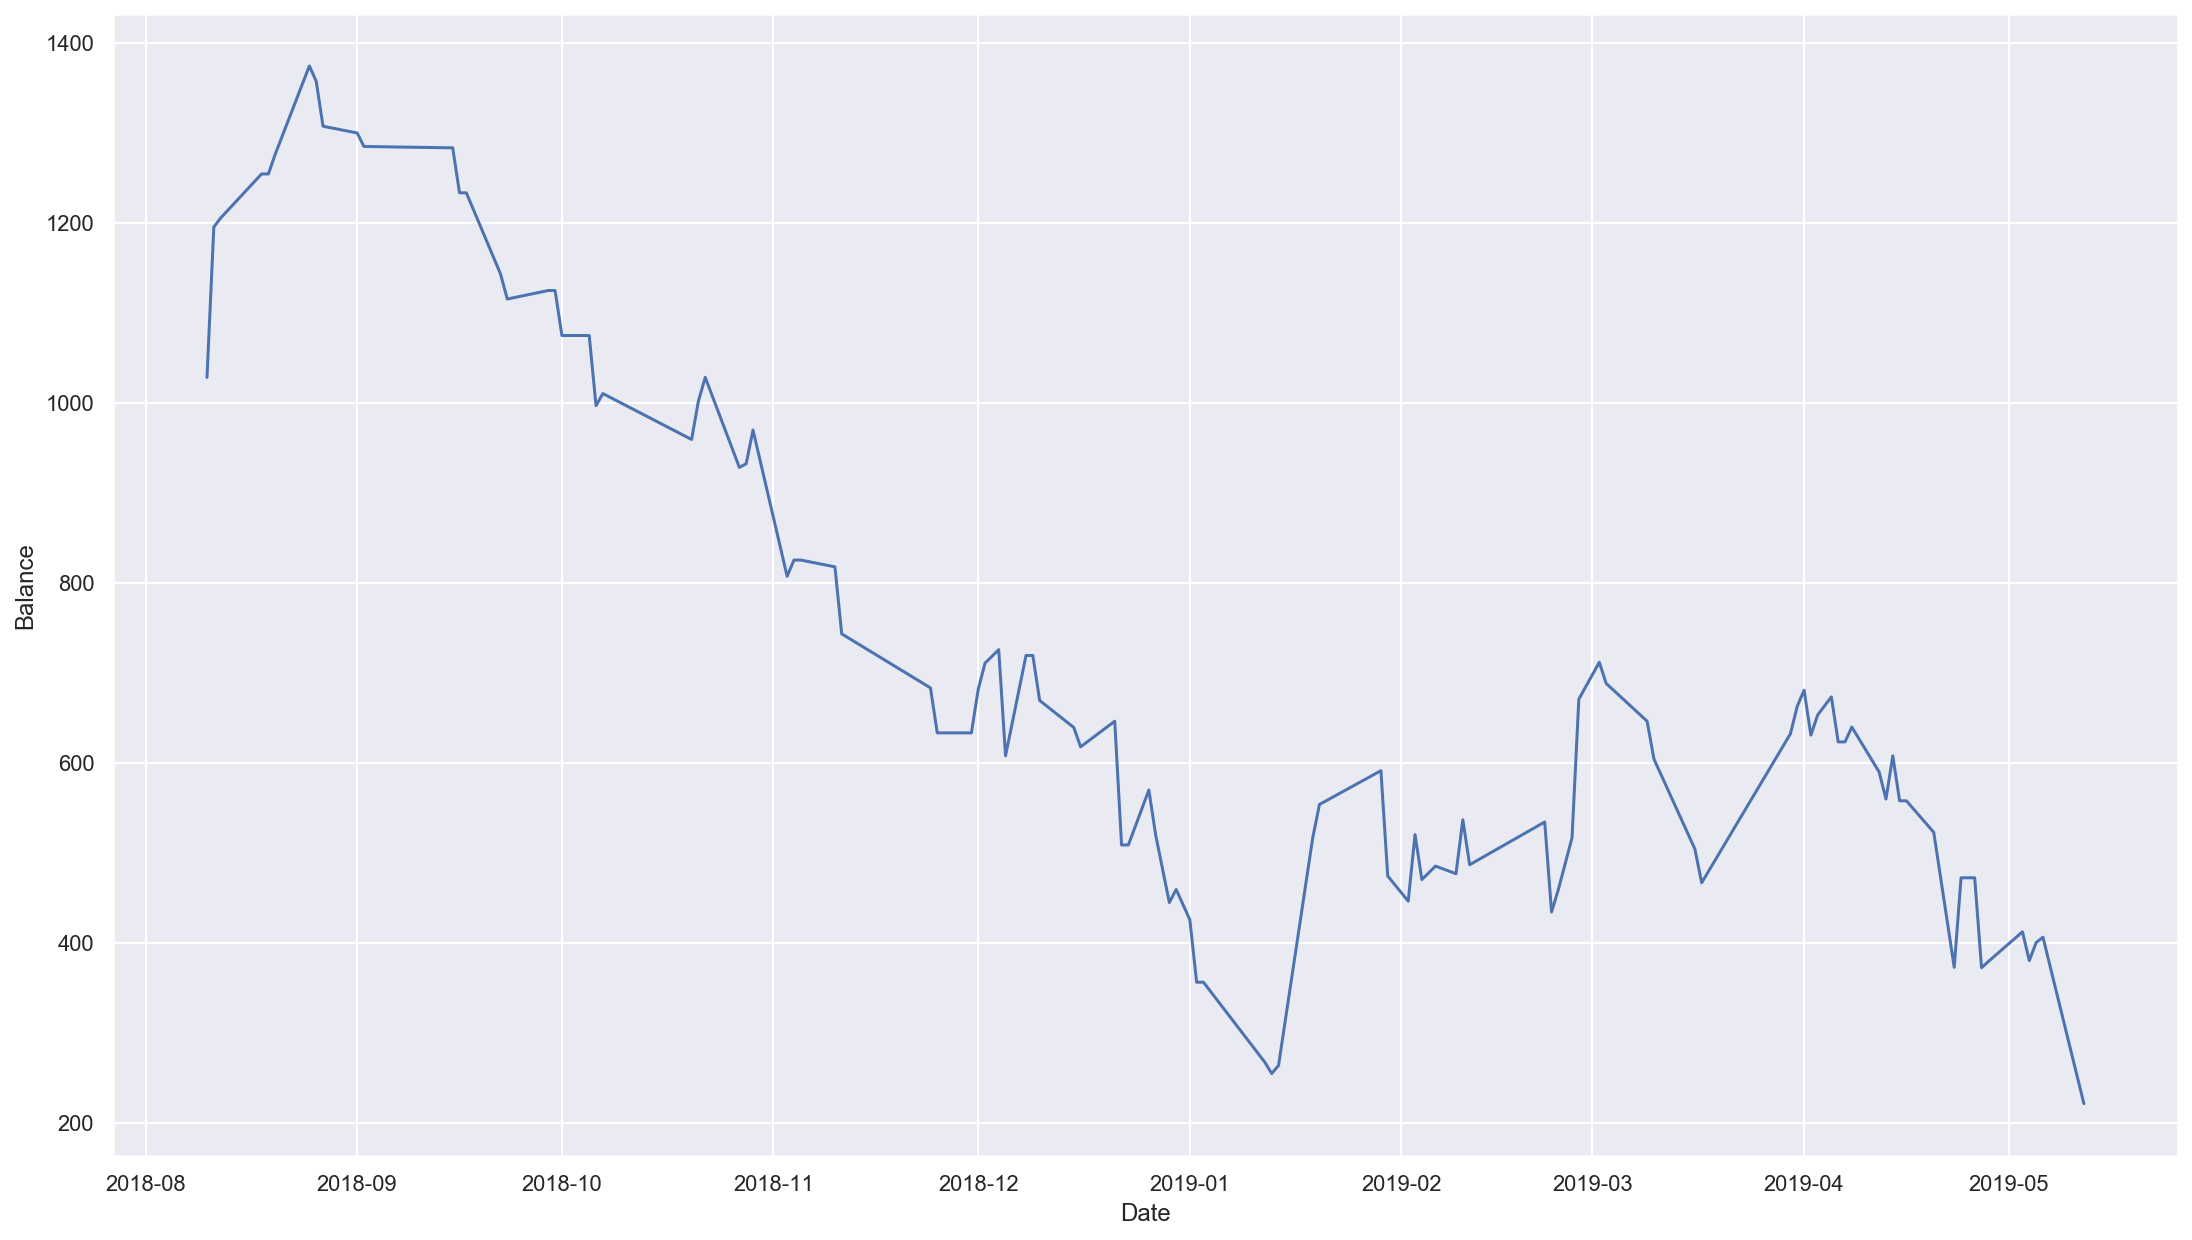

In [82]:
print(max(df_sim['Balance']))
print(min(df_sim['Balance']))
g = sns.lineplot(data=df_sim, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [83]:
import datetime
def next_draw_method(fixtures, starting_balance=1000):
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = [1000]
    dates = [datetime.datetime(fixtures['Date'].iloc[0].year,8,1)]
    receives = [0]
    bets = [0]
    profits = [0]
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        bet_today = 0
        receive_today = 0
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                bet_today += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    receive_today += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred = ''
                act = ''
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)
                odd = 0
                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

#                     balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
#                     odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_two
                        act = act_two
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                elif pred_one == 'Draw' or pred_two == 'Draw':
                    # if one of them predict Draw but the other does not, find next best
                    if pred_one == 'Draw':
                        lose_prob_two = predictions['LoseProb'].values[1]
                        win_prob_two = predictions['WinProb'].values[1]
                        if lose_prob_two > win_prob_two:
                            # guess a draw
                            team = predictions['Team'].values[0]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
#                         else:
#                             # do nothing
#                             pass
                    else:
                        lose_prob_one = predictions['LoseProb'].values[0]
                        win_prob_one = predictions['WinProb'].values[0]
                        if lose_prob_one > win_prob_one:
                            # guess a draw
                            team = predictions['Team'].values[1]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
                elif pred_one == pred_two == 'Lose':
                    # if both are losers, bet on draw
                    team = predictions['Team'].values[0]
                    pred = 'Draw'
                    if act_one == 'Draw':
                        odd = match['B365D']
                    act = act_one
                if pred != '':
                    balance += bet
                    bet_today += bet
                    print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                else:
                    print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
                    
                if odd != 0:
                    receive = bet * odd * -1
                    balance += receive
                    receive_today += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
                

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
        receives.append(receive_today)
        bets.append(bet_today)
        profits.append(receive_today + bet_today)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(1, len(dates) + 1),
        'Receive': receives,
        'Bet': bets,
        'Profit': profits
    })
    return df_sim

In [84]:
df_sim_nd_2017 = next_draw_method(fixtures)

Starting balance: 1000
2018-08-10 Pay: -50 on Man United in [ Man United vs Leicester ] Pred: Win Actual: Win Balance: 950
2018-08-10 Receive: 78.5 Odd: 1.57 Balance: 1028.5
2018-08-11 No bet in [ Bournemouth vs Cardiff ] Balance: 1028.5
2018-08-11 No bet in [ Fulham vs Crystal Palace ] Balance: 1028.5
2018-08-11 No bet in [ Huddersfield vs Chelsea ] Balance: 1028.5
2018-08-11 Pay: -50 on Tottenham in [ Newcastle vs Tottenham ] Pred: Win Actual: Win Balance: 978.5
2018-08-11 Receive: 102.0 Odd: 2.04 Balance: 1080.5
2018-08-11 No bet in [ Watford vs Brighton ] Balance: 1080.5
2018-08-11 Pay: -50 on Everton in [ Wolves vs Everton ] Pred: Draw Actual: Draw Balance: 1030.5
2018-08-11 Receive: 165.0 Odd: 3.3 Balance: 1195.5
2018-08-12 Pay: -50 on Man City in [ Arsenal vs Man City ] Pred: Win Actual: Win Balance: 1145.5
2018-08-12 Receive: 97.5 Odd: 1.95 Balance: 1243.0
2018-08-12 Pay: -50 on Liverpool in [ Liverpool vs West Ham ] Pred: Win Actual: Win Balance: 1193.0
2018-08-12 Receive: 62.

2018-11-03 Pay: -50 on West Ham in [ West Ham vs Burnley ] Pred: Win Actual: Win Balance: 1700.0
2018-11-03 Receive: 87.5 Odd: 1.75 Balance: 1787.5
2018-11-04 Pay: -50 on Chelsea in [ Chelsea vs Crystal Palace ] Pred: Win Actual: Win Balance: 1737.5
2018-11-04 Receive: 62.5 Odd: 1.25 Balance: 1800.0
2018-11-04 Pay: -50 on Man City in [ Man City vs Southampton ] Pred: Win Actual: Win Balance: 1750.0
2018-11-04 Receive: 55.50000000000001 Odd: 1.11 Balance: 1805.5
2018-11-05 No bet in [ Huddersfield vs Fulham ] Balance: 1805.5
2018-11-10 No bet in [ Cardiff vs Brighton ] Balance: 1805.5
2018-11-10 Pay: -50 on Tottenham in [ Crystal Palace vs Tottenham ] Pred: Win Actual: Win Balance: 1755.5
2018-11-10 Receive: 92.5 Odd: 1.85 Balance: 1848.0
2018-11-10 No bet in [ Huddersfield vs West Ham ] Balance: 1848.0
2018-11-10 No bet in [ Leicester vs Burnley ] Balance: 1848.0
2018-11-10 No bet in [ Newcastle vs Bournemouth ] Balance: 1848.0
2018-11-10 No bet in [ Southampton vs Watford ] Balance: 1

2019-01-12 Pay: -50 on Arsenal in [ West Ham vs Arsenal ] Pred: Draw Actual: Lose Balance: 1986.5
2019-01-12 No bet in [ Leicester vs Southampton ] Balance: 1986.5
2019-01-12 No bet in [ Crystal Palace vs Watford ] Balance: 1986.5
2019-01-12 No bet in [ Brighton vs Liverpool ] Balance: 1986.5
2019-01-12 No bet in [ Cardiff vs Huddersfield ] Balance: 1986.5
2019-01-12 No bet in [ Burnley vs Fulham ] Balance: 1986.5
2019-01-12 Pay: -50 on Chelsea in [ Chelsea vs Newcastle ] Pred: Win Actual: Win Balance: 1936.5
2019-01-12 Receive: 61.0 Odd: 1.22 Balance: 1997.5
2019-01-13 Pay: -50 on Everton in [ Everton vs Bournemouth ] Pred: Win Actual: Win Balance: 1947.5
2019-01-13 Receive: 87.5 Odd: 1.75 Balance: 2035.0
2019-01-13 No bet in [ Tottenham vs Man United ] Balance: 2035.0
2019-01-14 Pay: -50 on Man City in [ Man City vs Wolves ] Pred: Win Actual: Win Balance: 1985.0
2019-01-14 Receive: 59.0 Odd: 1.18 Balance: 2044.0
2019-01-19 No bet in [ Wolves vs Leicester ] Balance: 2044.0
2019-01-19 

2019-04-01 Pay: -50 on Arsenal in [ Arsenal vs Newcastle ] Pred: Win Actual: Win Balance: 2918.0
2019-04-01 Receive: 68.0 Odd: 1.36 Balance: 2986.0
2019-04-02 No bet in [ Watford vs Fulham ] Balance: 2986.0
2019-04-02 Pay: -50 on Man United in [ Wolves vs Man United ] Pred: Win Actual: Lose Balance: 2936.0
2019-04-03 Pay: -50 on Tottenham in [ Tottenham vs Crystal Palace ] Pred: Win Actual: Win Balance: 2886.0
2019-04-03 Receive: 72.5 Odd: 1.45 Balance: 2958.5
2019-04-03 No bet in [ Man City vs Cardiff ] Balance: 2958.5
2019-04-03 No bet in [ Chelsea vs Brighton ] Balance: 2958.5
2019-04-05 Pay: -50 on Liverpool in [ Southampton vs Liverpool ] Pred: Win Actual: Win Balance: 2908.5
2019-04-05 Receive: 70.0 Odd: 1.4 Balance: 2978.5
2019-04-06 Pay: -50 on Burnley in [ Bournemouth vs Burnley ] Pred: Lose Actual: Win Balance: 2928.5
2019-04-06 No bet in [ Huddersfield vs Leicester ] Balance: 2928.5
2019-04-06 Pay: -50 on Crystal Palace in [ Newcastle vs Crystal Palace ] Pred: Draw Actual: W

3292.5
1000.0


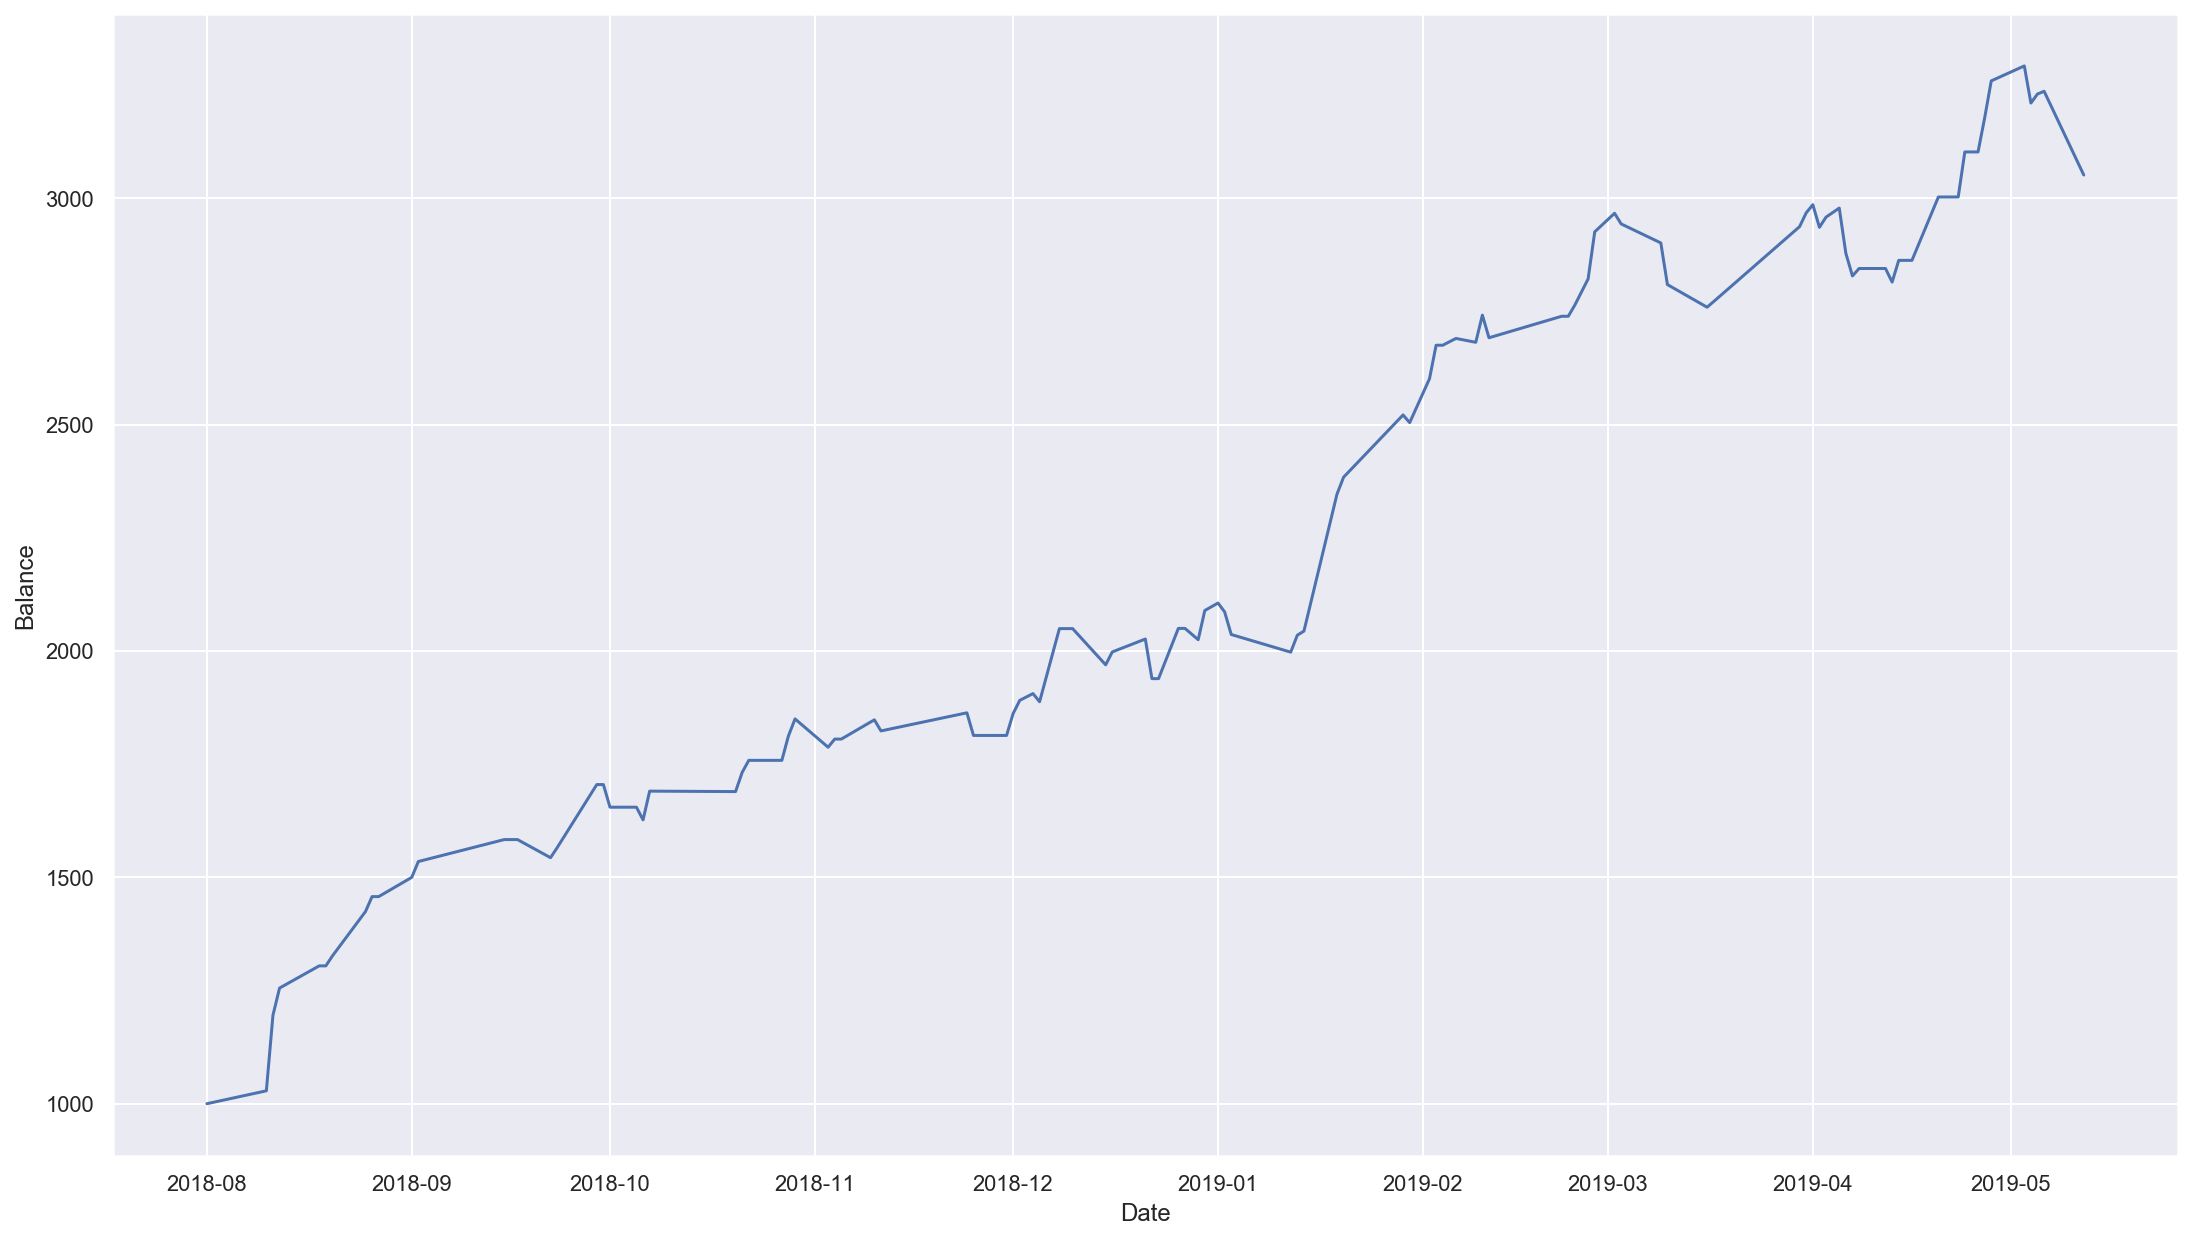

In [85]:
sns.set()
print(max(df_sim_nd_2017['Balance']))
print(min(df_sim_nd_2017['Balance']))
g = sns.lineplot(data=df_sim_nd_2017, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)